
# Modelación: Hidden Markov Model

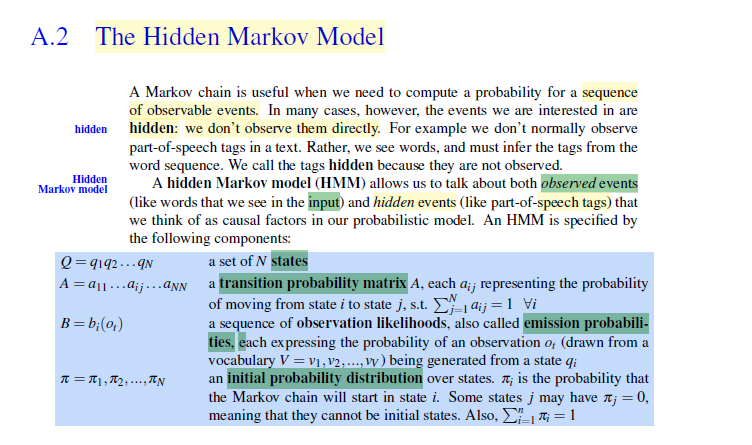

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from sklearn.cluster import KMeans
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import plotly.io as pio
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer_multidim
from pyclustering.utils.metric import distance_metric, type_metric
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy.stats import ttest_ind
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.stats import skew


In [3]:

csv_path = Path(r"e:\Maestría_Eafit2024\Maestria\Trabajo de grado\DataLab2\archive\data-science-project\data\stage\df_var_obs.csv")

df_XDB = pd.read_csv(csv_path, encoding="utf-8-sig")

df_XDB.head()


,Smoking,Family History of Anxiety,Stress Level,Diet Quality,Anxiety Level,Therapy Sessions (per month),Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Heart Rate (bpm)
0,False,True,0.000000,0.000000,0.4,1.000000,0.50,0.2,0.320534,0.966102
1,False,False,1.000000,0.222222,0.6,0.666667,1.00,0.6,0.612688,0.898305
2,False,False,1.000000,0.555556,1.0,0.111111,0.50,0.0,0.220367,0.322034
3,False,False,0.333333,1.000000,0.2,0.555556,0.50,0.2,0.602671,0.152542
4,False,False,0.222222,0.333333,0.6,0.666667,0.75,0.4,0.886477,0.084746


## Modelación de variables observables

### Preparación de los datos

Se crea la columnna de Fecha y ID para poder modelar el dataset con la metolodia de HMM

In [4]:

# Define cuántos pasos quieres por sujeto
T = 2
n = len(df_XDB)
n_ids = max(1, n // T)

# Asigna IDs
ids = np.repeat(np.arange(1, n_ids+1), T)[:n]
np.random.seed(42)
np.random.shuffle(ids)

df_XDB_ID = df_XDB.copy()
df_XDB_ID['ID'] = ids

# Crea una fecha simulada por ID con saltos aleatorios 
df_XDB_ID = df_XDB_ID.sort_values('ID').reset_index(drop=True)
df_XDB_ID['fecha'] = (
    pd.to_datetime("2025-01-01") 
    + pd.to_timedelta(
        df_XDB_ID.groupby('ID').cumcount().values * 30  # ~mensual
        + np.random.randint(0, 15, size=len(df_XDB_ID)), # irregularidad
        unit='D'
    )
)

# Orden final y 'time'
df_XDB_ID = df_XDB_ID.sort_values(['ID','fecha']).reset_index(drop=True)
df_XDB_ID['time'] = df_XDB_ID.groupby('ID').cumcount() + 1

In [5]:
df_XDB_ID.head(10)

,Smoking,Family History of Anxiety,Stress Level,Diet Quality,Anxiety Level,Therapy Sessions (per month),Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Heart Rate (bpm),ID,fecha,time
0,False,False,0.111111,0.777778,0.4,0.444444,0.50,0.8,0.779633,0.118644,1,2025-01-03,1
1,False,True,0.888889,0.111111,0.4,0.000000,0.25,0.6,0.293823,0.728814,1,2025-01-31,2
2,True,False,1.000000,0.000000,1.0,1.000000,0.00,0.0,0.816361,0.627119,2,2025-01-08,1
3,False,False,0.666667,0.000000,1.0,0.888889,0.25,0.0,0.218698,0.610169,2,2025-02-12,2
4,False,False,1.000000,0.333333,1.0,0.888889,1.00,0.6,0.984975,0.711864,3,2025-01-13,1
5,True,False,0.555556,0.555556,0.6,0.333333,0.75,0.2,0.420701,0.694915,3,2025-02-09,2
6,False,False,0.555556,0.333333,0.8,0.333333,0.75,0.8,0.026711,0.847458,4,2025-01-14,1
7,True,False,0.000000,0.333333,0.0,0.000000,0.75,1.0,0.330551,0.677966,4,2025-02-10,2
8,False,False,0.000000,0.111111,0.2,0.333333,0.50,0.2,0.824708,0.542373,5,2025-01-15,1
9,True,False,0.111111,0.333333,0.2,0.111111,0.00,0.4,0.871452,0.016949,5,2025-02-10,2


### Procesamiento de datos

In [6]:
# Orden temporal por ID y fecha 
df_XDB_ID["fecha"] = pd.to_datetime(df_XDB_ID["fecha"], errors="coerce")
df_XDB_ID = df_XDB_ID.sort_values(["ID", "fecha", "time"], na_position="last").reset_index(drop=True)


# VARIABLE NO OBSERVABLE (Y_d)
# ------------------------------
# Tomamos Anxiety Level como *proxy* de la variable latente y la convertimos a [0,1]
y_cont = df_XDB_ID["Anxiety Level"].astype(float).values.reshape(-1, 1)
y_cont = MinMaxScaler().fit_transform(y_cont)   # 0=sano ... 1=peor 



In [7]:
df_XDB_ID.head()

,Smoking,Family History of Anxiety,Stress Level,Diet Quality,Anxiety Level,Therapy Sessions (per month),Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Heart Rate (bpm),ID,fecha,time
0,False,False,0.111111,0.777778,0.4,0.444444,0.50,0.8,0.779633,0.118644,1,2025-01-03,1
1,False,True,0.888889,0.111111,0.4,0.000000,0.25,0.6,0.293823,0.728814,1,2025-01-31,2
2,True,False,1.000000,0.000000,1.0,1.000000,0.00,0.0,0.816361,0.627119,2,2025-01-08,1
3,False,False,0.666667,0.000000,1.0,0.888889,0.25,0.0,0.218698,0.610169,2,2025-02-12,2
4,False,False,1.000000,0.333333,1.0,0.888889,1.00,0.6,0.984975,0.711864,3,2025-01-13,1


In [8]:
display(y_cont)

array([[0.4],
       [0.4],
       [1. ],
       ...,
       [0.6],
       [0.8],
       [1. ]])

### Modelación y seleccion de variables observables

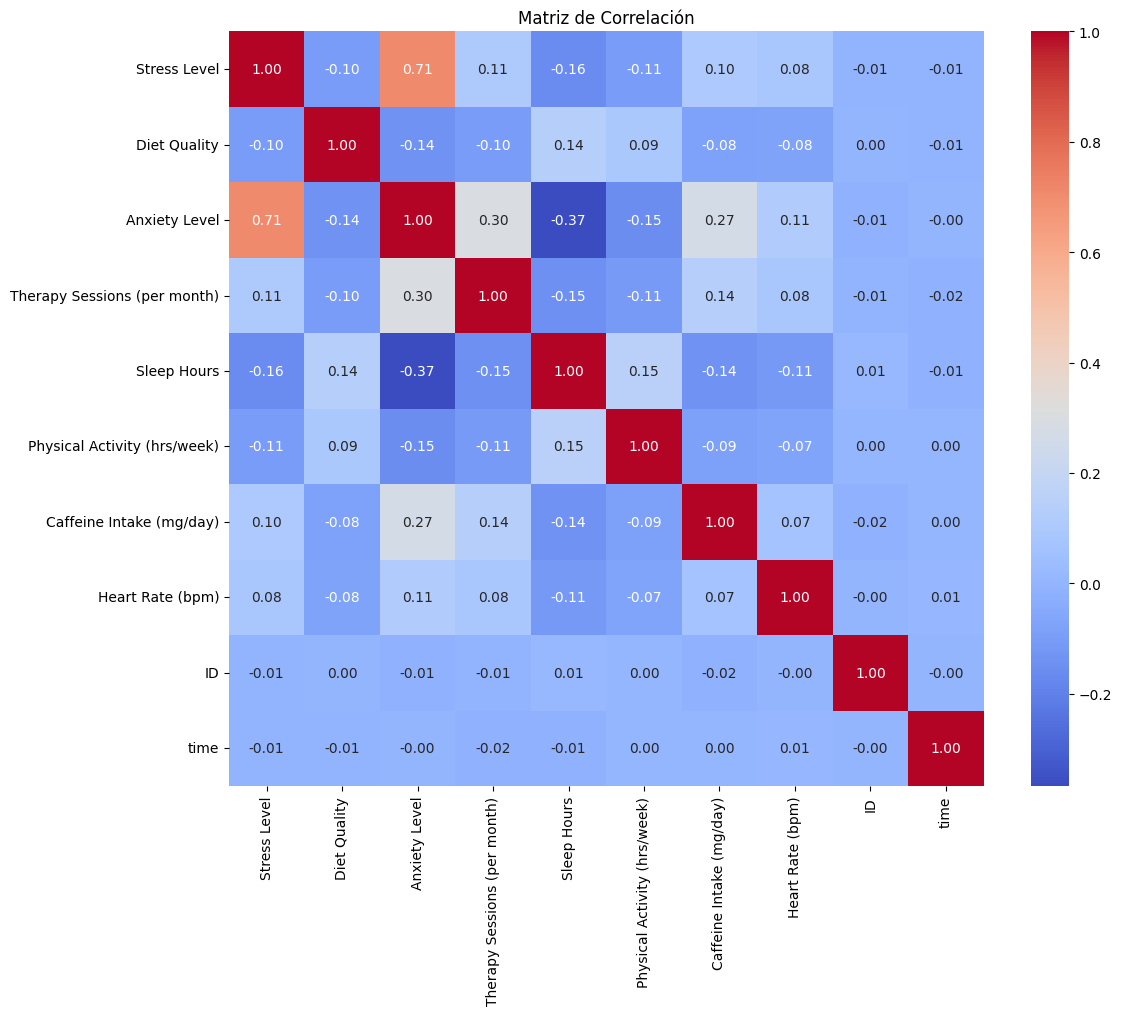

In [9]:
# Matriz de correlación
corr = df_XDB_ID.select_dtypes(include=['number']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación")
plt.tight_layout()
plt.show()

Selección de variables mas explicativas

In [10]:
cols2 = [
    'Smoking', 'Stress Level',
    'Therapy Sessions (per month)', 'Sleep Hours', 'Anxiety Level',
    'Physical Activity (hrs/week)'
]

cols_exist = [col for col in cols2 if col in df_XDB_ID.columns]
df_selected_2  = df_XDB_ID[cols_exist].copy()

df_selected_2.head()

,Smoking,Stress Level,Therapy Sessions (per month),Sleep Hours,Anxiety Level,Physical Activity (hrs/week)
0,False,0.111111,0.444444,0.50,0.4,0.8
1,False,0.888889,0.000000,0.25,0.4,0.6
2,True,1.000000,1.000000,0.00,1.0,0.0
3,False,0.666667,0.888889,0.25,1.0,0.0
4,False,1.000000,0.888889,1.00,1.0,0.6


### Correlaciones parciales - Pearson

📊 Matriz de correlaciones parciales (primeras columnas):
                              Stress Level  Therapy Sessions (per month)  \
Stress Level                         1.000                        -0.147   
Therapy Sessions (per month)        -0.147                         1.000   
Sleep Hours                          0.147                        -0.015   
Anxiety Level                        0.709                         0.282   
Physical Activity (hrs/week)        -0.020                        -0.066   

                              Sleep Hours  Anxiety Level  \
Stress Level                        0.147          0.709   
Therapy Sessions (per month)       -0.015          0.282   
Sleep Hours                         1.000         -0.335   
Anxiety Level                      -0.335          1.000   
Physical Activity (hrs/week)        0.104         -0.047   

                              Physical Activity (hrs/week)  
Stress Level                                        -0.020  
The

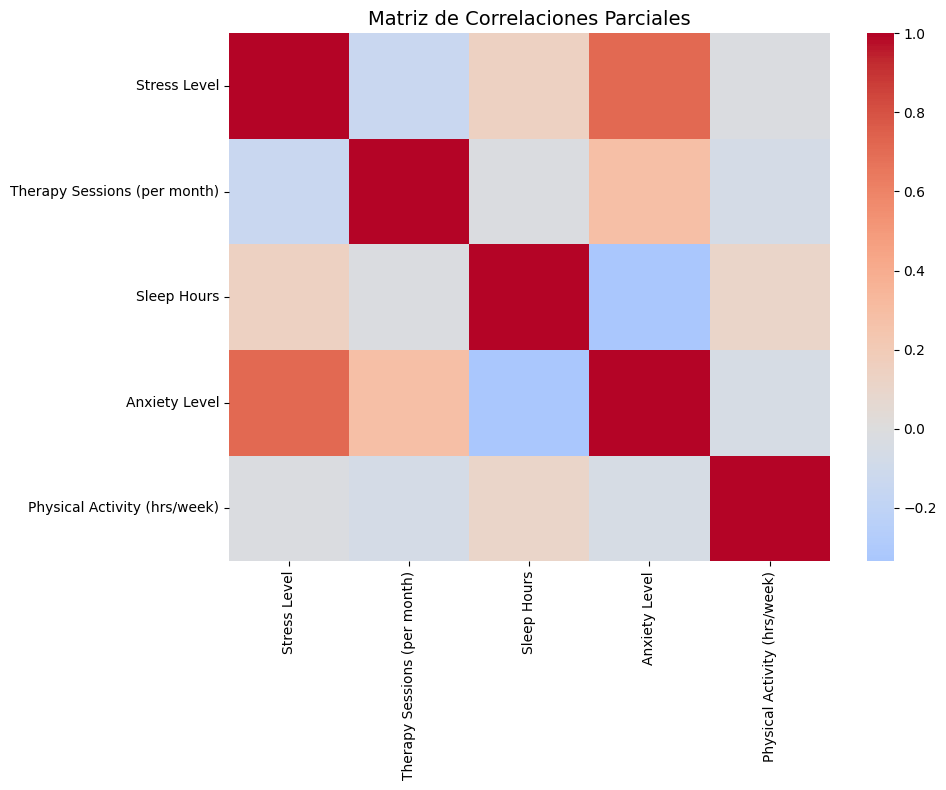

In [11]:
# ==========================================
# 📘 Cálculo de correlaciones parciales
# ==========================================

df = df_selected_2.copy()

df_numeric = df.select_dtypes(include=[np.number]).dropna()

#  Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# Calcular la matriz de correlación de Pearson
corr_matrix = np.corrcoef(X_scaled, rowvar=False)

# Regularización para evitar singularidad (ridge regularization)
ridge = 1e-5
corr_matrix_reg = corr_matrix + ridge * np.eye(corr_matrix.shape[0])

# Invertir la matriz de correlación regularizada
precision_matrix = np.linalg.inv(corr_matrix_reg)

# Calcular correlaciones parciales
D = np.sqrt(np.diag(precision_matrix))
partial_corr_matrix = -precision_matrix / np.outer(D, D)
np.fill_diagonal(partial_corr_matrix, 1)

# Convertir a DataFrame
partial_corr_df = pd.DataFrame(
    partial_corr_matrix,
    index=df_numeric.columns,
    columns=df_numeric.columns
)


print("📊 Matriz de correlaciones parciales (primeras columnas):")
print(partial_corr_df.round(3).iloc[:10, :10])

# Visualizar la matriz de correlaciones parciales
plt.figure(figsize=(10, 8))
sns.heatmap(partial_corr_df, cmap="coolwarm", center=0, annot=False)
plt.title("Matriz de Correlaciones Parciales", fontsize=14)
plt.tight_layout()
plt.show()


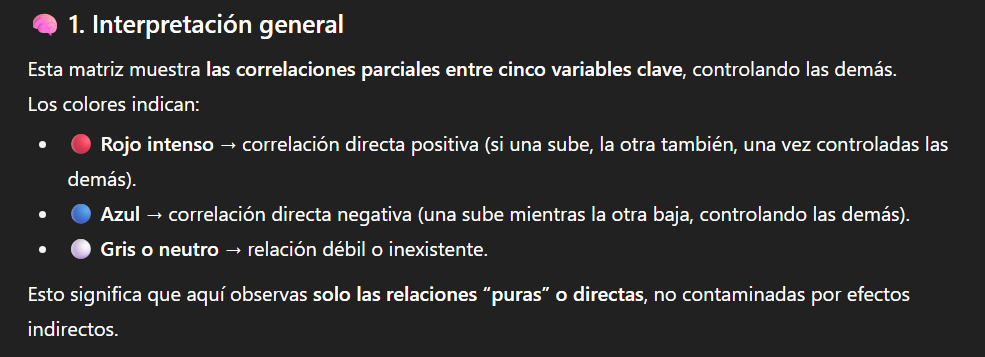

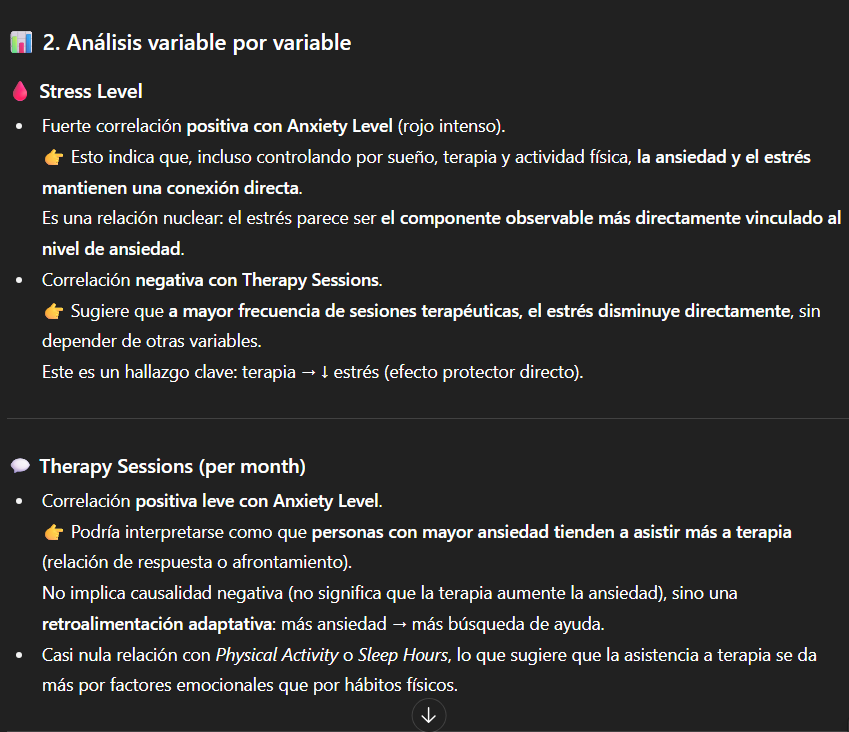

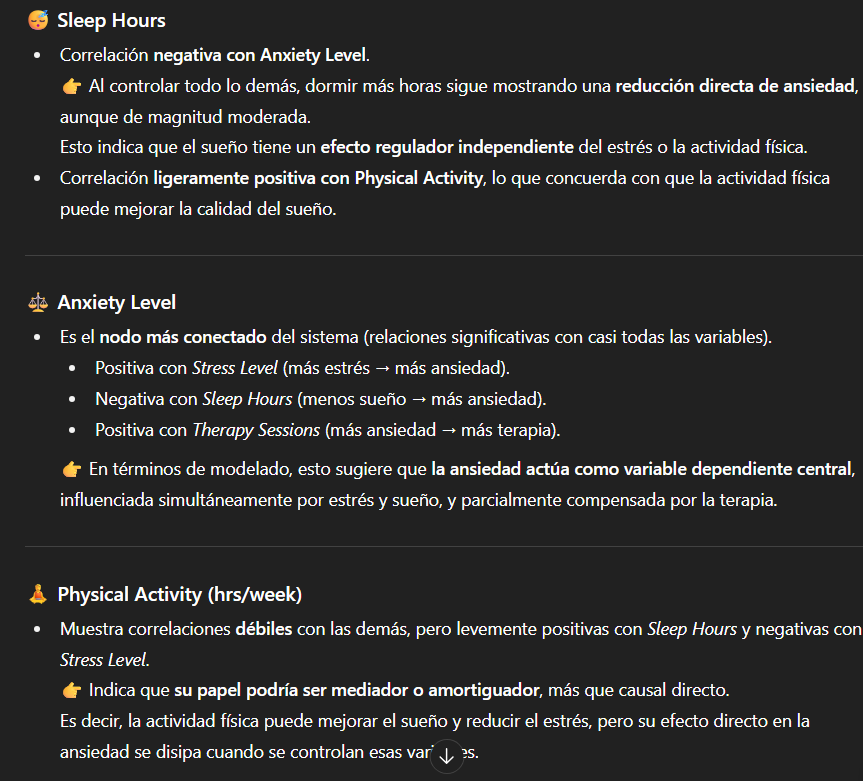

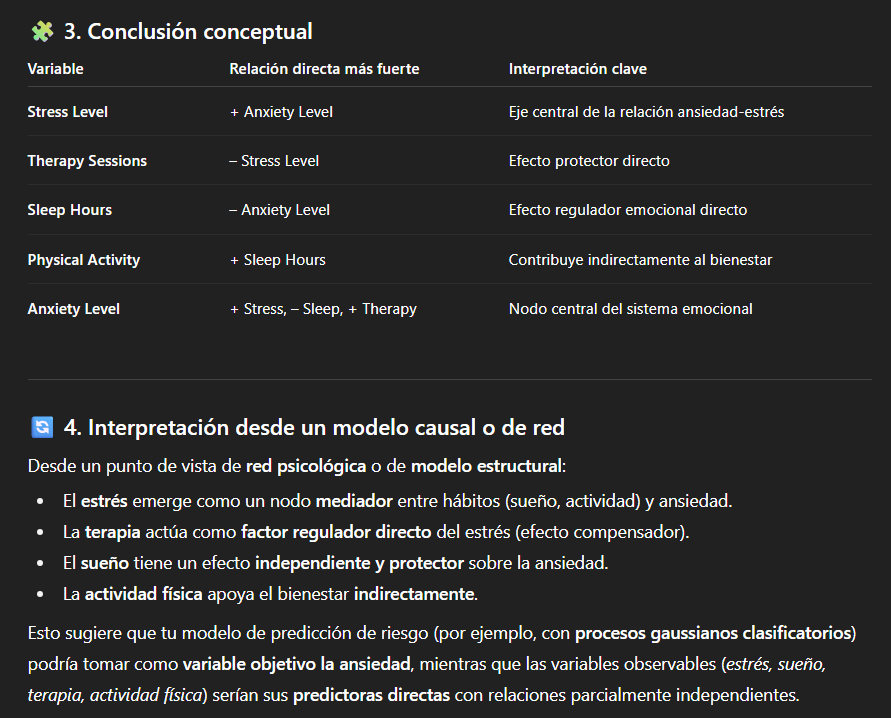

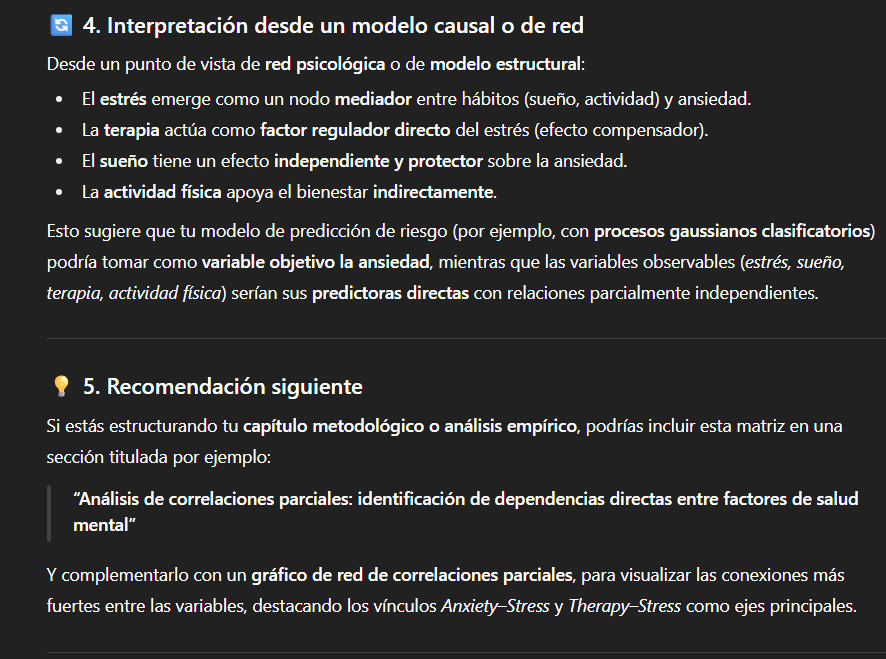

### Analisis de la variable binaria

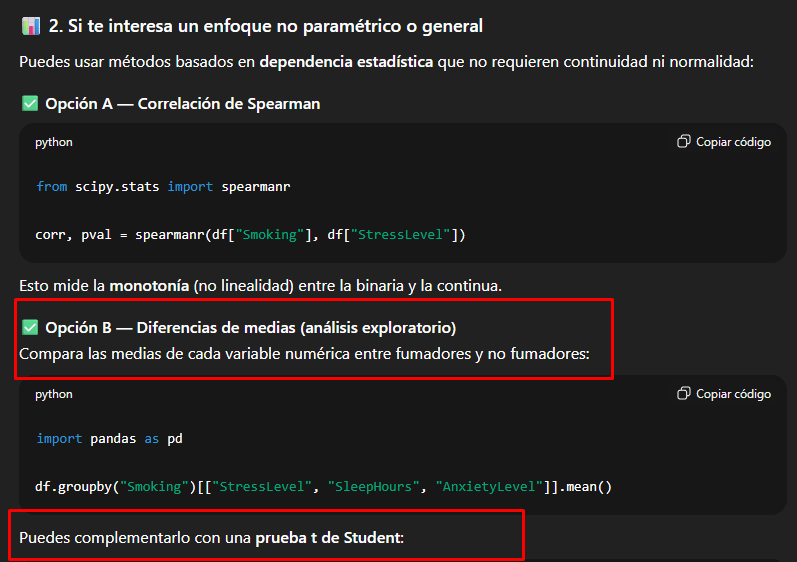

In [12]:
df.groupby("Smoking")[["Stress Level", "Sleep Hours", "Anxiety Level"]].mean()


,Stress Level,Sleep Hours,Anxiety Level
Smoking,,,
False,0.533563,0.546716,0.547378
True,0.542547,0.516993,0.551669


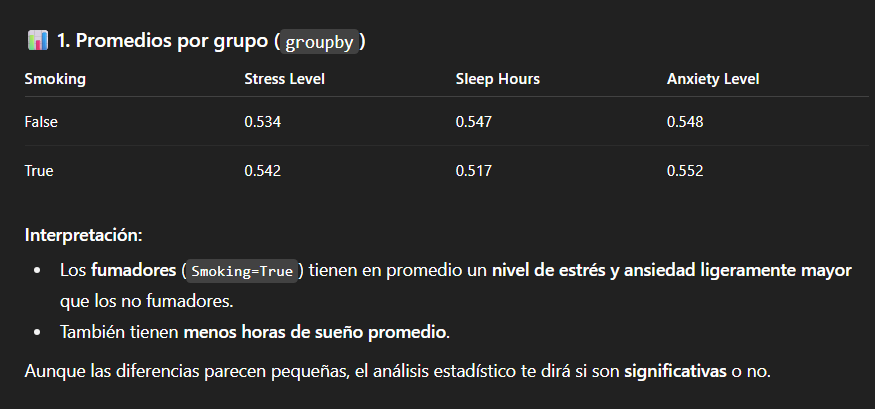

In [13]:
smokers = df[df["Smoking"]==1]["Stress Level"]
nonsmokers = df[df["Smoking"]==0]["Stress Level"]

t, p = ttest_ind(smokers, nonsmokers)
print(f"t={t:.3f}, p={p:.4f}")


t=1.979, p=0.0478


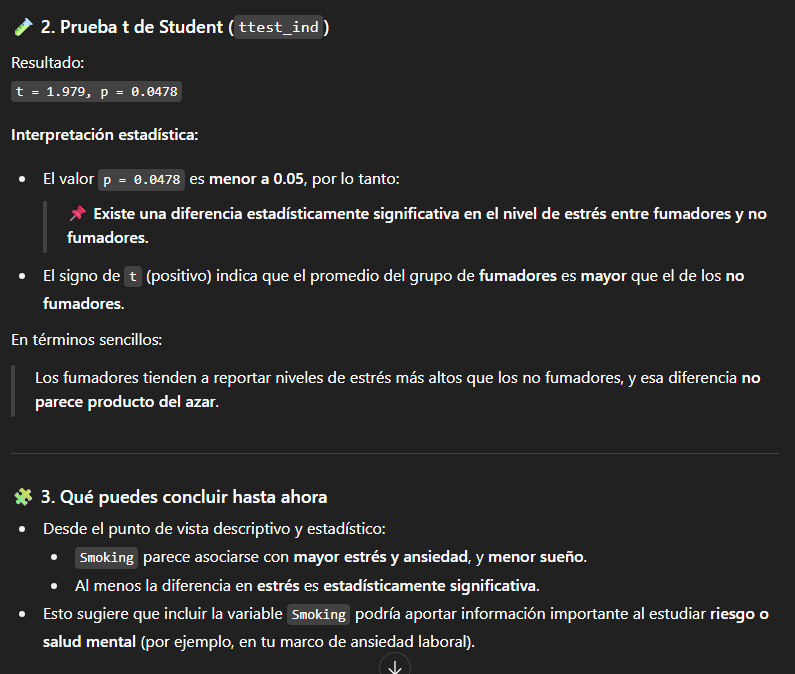

In [14]:
for var in ["Stress Level", "Sleep Hours", "Anxiety Level"]:
    smokers = df[df["Smoking"]==1][var]
    nonsmokers = df[df["Smoking"]==0][var]
    t, p = ttest_ind(smokers, nonsmokers)
    print(f"{var}: t={t:.3f}, p={p:.4f}")


Stress Level: t=1.979, p=0.0478
Sleep Hours: t=-6.729, p=0.0000
Anxiety Level: t=1.004, p=0.3156


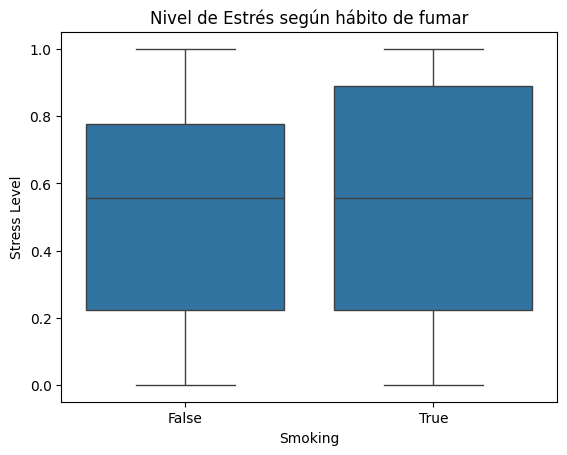

In [15]:
sns.boxplot(x="Smoking", y="Stress Level", data=df)
plt.title("Nivel de Estrés según hábito de fumar")
plt.show()


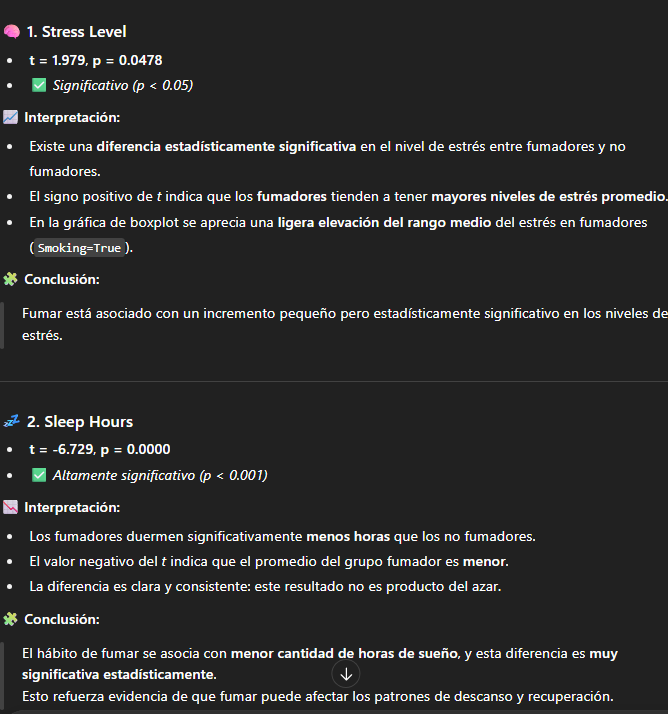

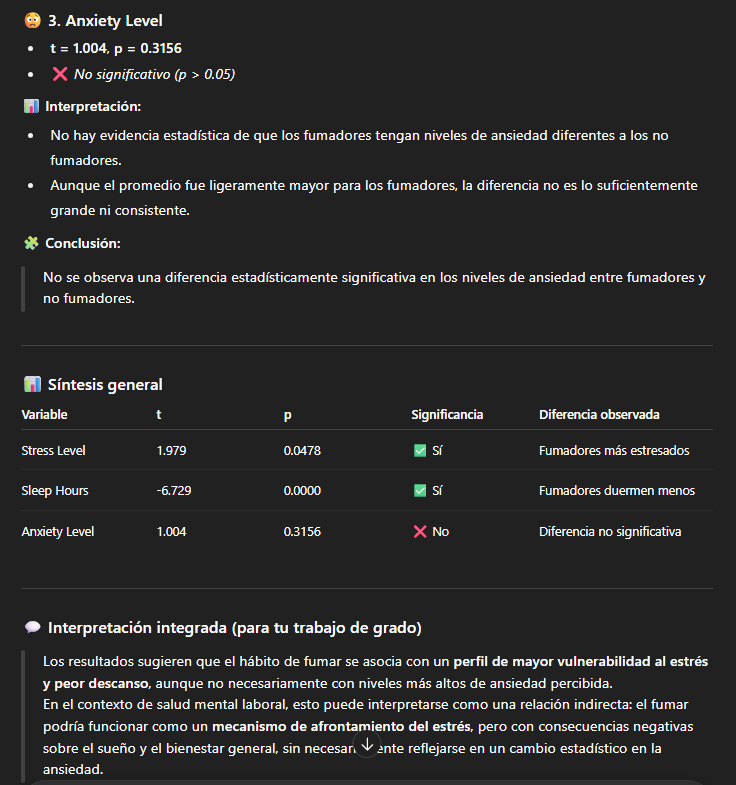

### Correlación multiple

In [16]:
# ==========================================
#  Correlación múltiple (R) con statsmodels
# ==========================================

# ---------- Utilidades ----------
def multiple_correlation(y: pd.Series, X: pd.DataFrame, standardize=True):
    """
    Devuelve R, R2, R2_ajustado, F, p_global y coeficientes beta estandarizados.
    y: variable objetivo (Series)
    X: predictores (DataFrame)
    """
    # Quitar filas con NaN en y o X
    data = pd.concat([y, X], axis=1).dropna()
    y_clean = data.iloc[:, 0].astype(float)
    X_clean = data.iloc[:, 1:].astype(float)

    # Estandarizar (opcional, útil para betas comparables)
    if standardize:
        scaler = StandardScaler()
        X_std = pd.DataFrame(scaler.fit_transform(X_clean), columns=X_clean.columns, index=X_clean.index)
        y_std = pd.Series(StandardScaler().fit_transform(y_clean.values.reshape(-1,1)).ravel(),
                          name=y_clean.name, index=y_clean.index)
    else:
        X_std, y_std = X_clean, y_clean

    # Ajuste OLS
    X_sm = sm.add_constant(X_std)
    model = sm.OLS(y_std, X_sm).fit()

    R2 = model.rsquared
    R = np.sqrt(max(R2, 0))
    R2_adj = model.rsquared_adj
    F = model.fvalue
    p_global = model.f_pvalue

    # Coeficientes beta (al estar estandarizado, son betas estandarizadas)
    betas = model.params.drop('const')
    betas = betas.sort_values(key=lambda s: s.abs(), ascending=False)

    return {
        "R": R,
        "R2": R2,
        "R2_adj": R2_adj,
        "F": F,
        "p_global": p_global,
        "betas_std": betas,
        "resumen_modelo": model.summary()
    }

def multiple_correlation_for_all(df: pd.DataFrame, standardize=True):
    """
    Calcula R de correlación múltiple para cada columna como objetivo frente al resto.
    Devuelve un DataFrame con R, R2, R2_ajustado y p_global.
    """
    df_num = df.select_dtypes(include=[np.number, "bool"])
    results = []
    for target in df_num.columns:
        X = df_num.drop(columns=[target])
        y = df_num[target]
        out = multiple_correlation(y, X, standardize=standardize)
        results.append({
            "target": target,
            "R": out["R"],
            "R2": out["R2"],
            "R2_adj": out["R2_adj"],
            "p_global": out["p_global"]
        })
    return pd.DataFrame(results).sort_values("R", ascending=False)


#  Cargar tu dataset
df = df_selected_2.copy()


#  Correlación múltiple para un objetivo específico (p. ej., Anxiety Level)
target_col = "Anxiety Level"              # <- cambia aquí si quieres otra
X = df.drop(columns=[target_col]).select_dtypes(include=[np.number, "bool"])
y = df[target_col]

res = multiple_correlation(y, X, standardize=True)

print(f"Objetivo: {target_col}")
print(f"R = {res['R']:.3f} | R2 = {res['R2']:.3f} | R2 ajustado = {res['R2_adj']:.3f}")
print(f"F = {res['F']:.3f} | p global = {res['p_global']:.3g}\n")
print("Betas estandarizadas (ordenadas por |β|):")
print(res["betas_std"].round(3))
# Si quieres ver el resumen OLS completo:
# print(res["resumen_modelo"])

# R múltiple para todas las columnas como objetivo
tabla_R = multiple_correlation_for_all(df)
print("\nCorrelación múltiple por variable objetivo:")
print(tabla_R.round(3))


Objetivo: Anxiety Level
R = 0.776 | R2 = 0.602 | R2 ajustado = 0.602
F = 6655.555 | p global = 0

Betas estandarizadas (ordenadas por |β|):
Stress Level                    0.646
Sleep Hours                    -0.231
Therapy Sessions (per month)    0.190
Physical Activity (hrs/week)   -0.030
Smoking                         0.006
dtype: float64

Correlación múltiple por variable objetivo:
                         target      R     R2  R2_adj  p_global
4                 Anxiety Level  0.776  0.602   0.602       0.0
1                  Stress Level  0.722  0.521   0.521       0.0
3                   Sleep Hours  0.408  0.166   0.166       0.0
2  Therapy Sessions (per month)  0.351  0.123   0.123       0.0
5  Physical Activity (hrs/week)  0.198  0.039   0.039       0.0
0                       Smoking  0.120  0.014   0.014       0.0


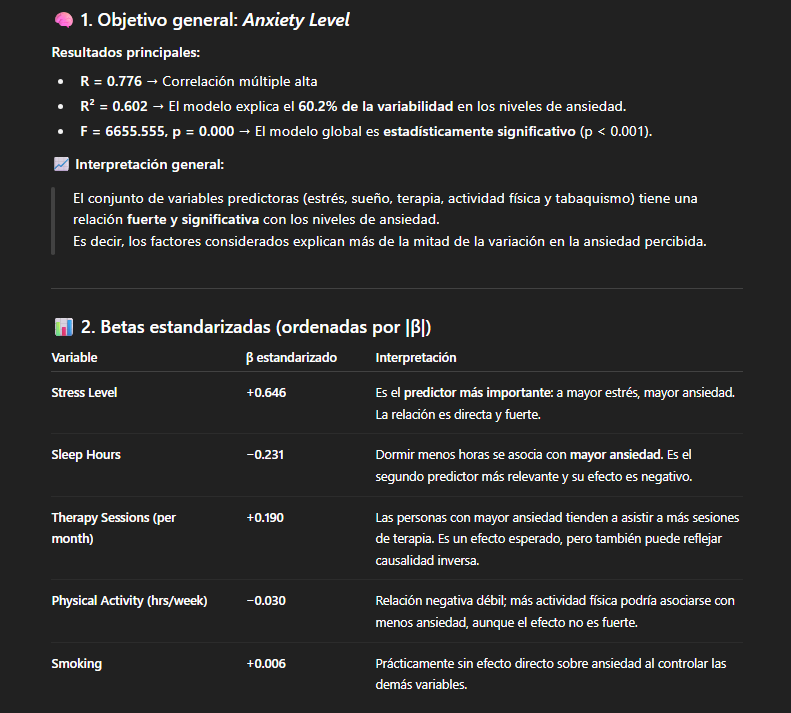

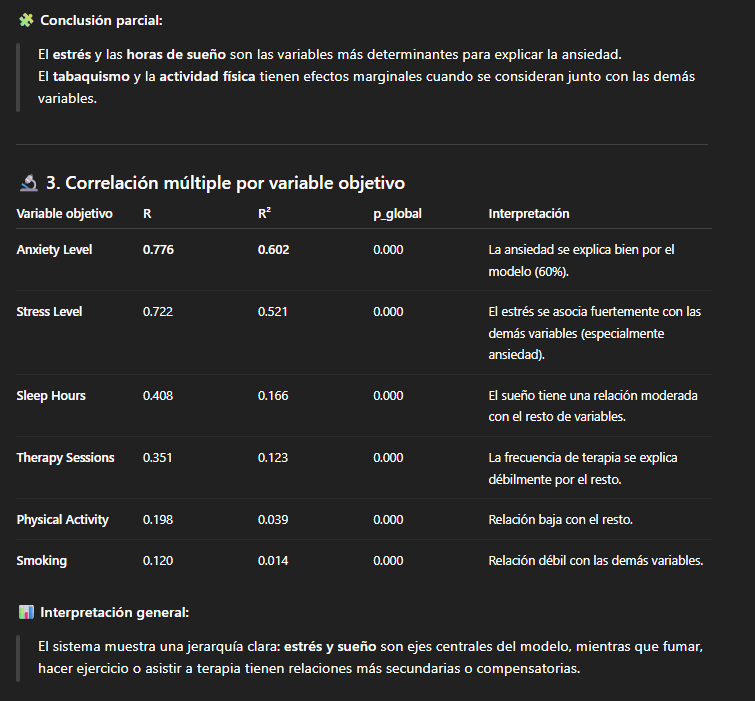

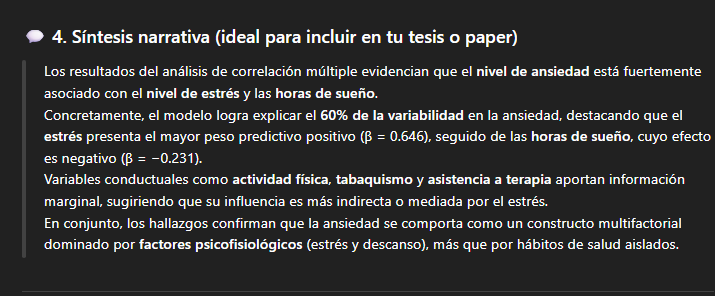

In [17]:
# ==========================================
# Correlación múltiple sin "Physical Activity (hrs/week)"
# ==========================================



# ---------- Cargar dataset ----------
df = df_selected_2.copy()

# ---------- Variable objetivo ----------
target_col = "Anxiety Level"

# ---------- Construir X excluyendo la variable deseada ----------
cols_to_exclude = [target_col, "Physical Activity (hrs/week)"]
X = df.drop(columns=cols_to_exclude).select_dtypes(include=[np.number, "bool"])
y = df[target_col]

# ---------- Calcular correlación múltiple ----------
res = multiple_correlation(y, X, standardize=True)

print(f"Objetivo: {target_col}")
print(f"R = {res['R']:.3f} | R2 = {res['R2']:.3f} | R2 ajustado = {res['R2_adj']:.3f}")
print(f"F = {res['F']:.3f} | p global = {res['p_global']:.3g}\n")
print("Betas estandarizadas (ordenadas por |β|):")
print(res["betas_std"].round(3))

# ---------- (Opcional) Comparar con el modelo completo ----------
tabla_R = multiple_correlation_for_all(df.drop(columns=["Physical Activity (hrs/week)"]))
print("\nCorrelación múltiple por variable objetivo (sin Physical Activity):")
print(tabla_R.round(3))


Objetivo: Anxiety Level
R = 0.775 | R2 = 0.601 | R2 ajustado = 0.601
F = 8289.309 | p global = 0

Betas estandarizadas (ordenadas por |β|):
Stress Level                    0.648
Sleep Hours                    -0.235
Therapy Sessions (per month)    0.192
Smoking                         0.007
dtype: float64

Correlación múltiple por variable objetivo (sin Physical Activity):
                         target      R     R2  R2_adj  p_global
4                 Anxiety Level  0.775  0.601   0.601       0.0
1                  Stress Level  0.722  0.521   0.521       0.0
3                   Sleep Hours  0.397  0.157   0.157       0.0
2  Therapy Sessions (per month)  0.345  0.119   0.119       0.0
0                       Smoking  0.118  0.014   0.014       0.0


### Reducción y clusterización de variables observables

Varianza explicada por los 3 primeros componentes: 0.8010850162213942


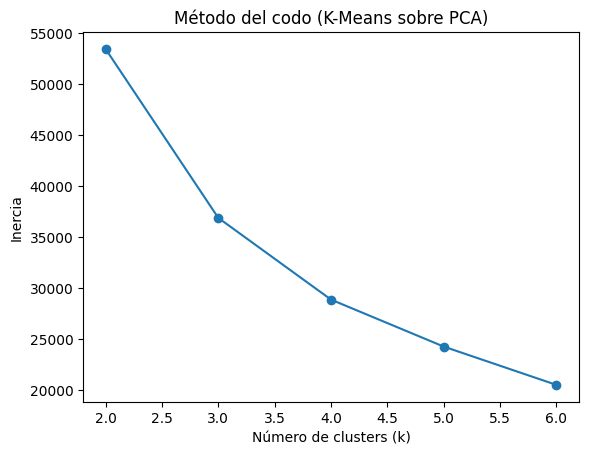

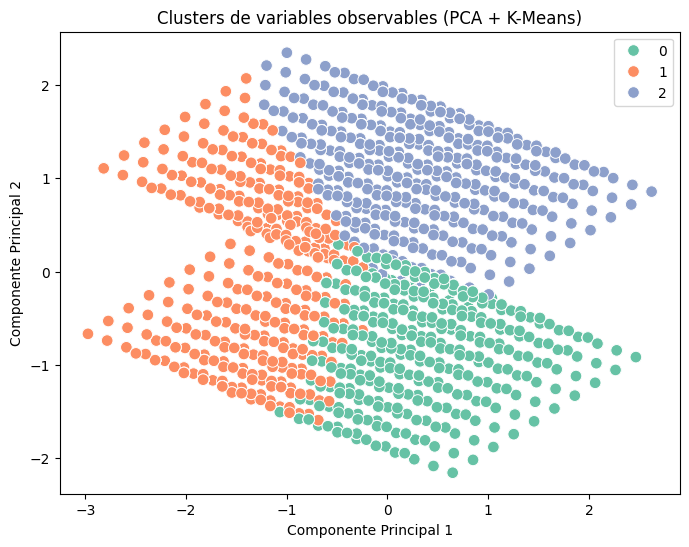

In [18]:

#  Cargar dataset y seleccionar variables observables
df = df_selected_2.copy()
observables = ["Stress Level", "Sleep Hours", "Therapy Sessions (per month)","Smoking"] #,"Physical Activity (hrs/week)" ,"Smoking"
X = df[observables].dropna()

# Escalamiento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=3)   
X_pca = pca.fit_transform(X_scaled)
print("Varianza explicada por los 3 primeros componentes:", pca.explained_variance_ratio_.sum())

# Determinar número óptimo de clusters (Método del codo)
inertia = []
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_pca)
    inertia.append(km.inertia_)

plt.plot(range(2, 7), inertia, 'o-')
plt.title("Método del codo (K-Means sobre PCA)")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.show()

# Elegir k óptimo  y clusterizar
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Agregar el cluster como nueva variable sintética
df["Behavioral_Cluster"] = clusters

# Visualización en el espacio PCA
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette="Set2", s=70)
plt.title("Clusters de variables observables (PCA + K-Means)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()

# Crear una variable numérica latente (distancia al centroide o proyección)
df["Behavioral_Index"] = kmeans.transform(X_pca).min(axis=1)
df["Behavioral_Index"] = 1 - (df["Behavioral_Index"] - df["Behavioral_Index"].min()) / (df["Behavioral_Index"].max() - df["Behavioral_Index"].min())


Varianza explicada por los 3 componentes: 0.8010850162213942


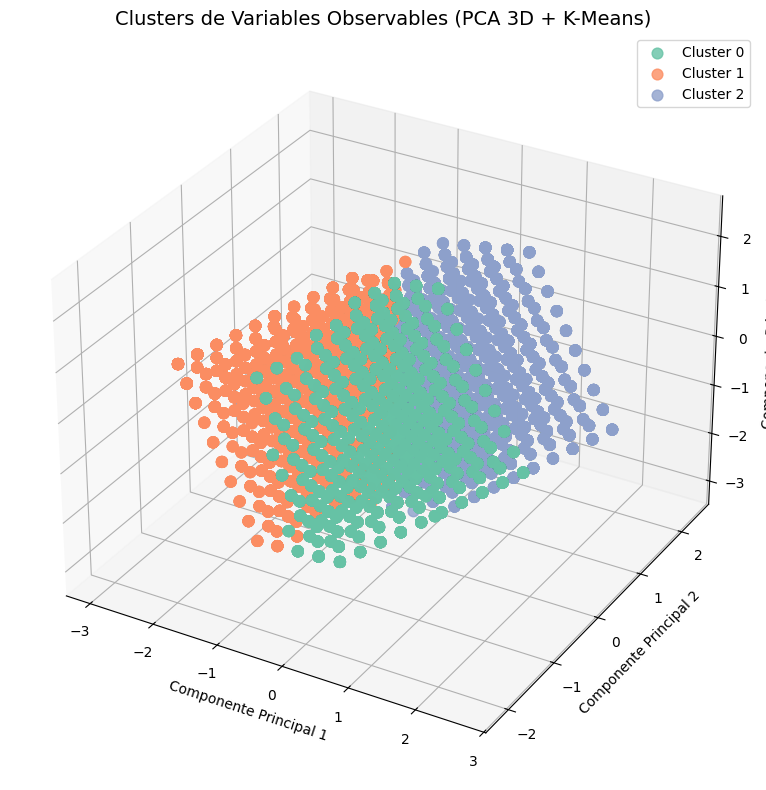

In [19]:
# ==========================================
# Clustering con PCA (3D) y K-Means
# ==========================================


#  Cargar dataset
df = df_selected_2

# Definir variables observables
observables = ["Stress Level", "Sleep Hours", "Therapy Sessions (per month)", "Smoking"] #, "Smoking","Physical Activity (hrs/week)"
X = df[observables].dropna()

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reducir dimensionalidad a 3 componentes con PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
print("Varianza explicada por los 3 componentes:", pca.explained_variance_ratio_.sum())

# Aplicar K-Means (ajusta k según el método del codo anterior)
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# gregar resultados al dataframe
df["Cluster"] = clusters
df["PC1"], df["PC2"], df["PC3"] = X_pca[:, 0], X_pca[:, 1], X_pca[:, 2]

# Graficar en 3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

colors = sns.color_palette("Set2", k_opt)

for i in range(k_opt):
    subset = df[df["Cluster"] == i]
    ax.scatter(subset["PC1"], subset["PC2"], subset["PC3"], 
               s=60, alpha=0.8, color=colors[i], label=f"Cluster {i}")

# Etiquetas y detalles
ax.set_title("Clusters de Variables Observables (PCA 3D + K-Means)", fontsize=14)
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.legend()
plt.tight_layout()
plt.show()

# Calcular un índice continuo de bienestar observable
df["Behavioral_Index"] = 1 - (kmeans.transform(X_pca).min(axis=1) / np.max(kmeans.transform(X_pca)))


In [20]:

#  Configurar renderizador
# ==========================

pio.renderers.default = "browser"   # abrirá el gráfico en tu navegador por defecto


# Cargar dataset
# ==========================
df_selected = df_selected_2.copy()


# Variables observables (quitamos Anxiety Level)
# ==========================
observables = df_selected.drop(columns=["Anxiety Level"]).dropna()


# Ajustar K-Means con k=3
# ==========================
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_selected["Cluster_KMeans"] = kmeans.fit_predict(observables)


# Reducir a 3D con PCA
# ==========================
pca = PCA(n_components=3, random_state=42)
X3 = pca.fit_transform(observables)

df_selected["PC1"] = X3[:, 0]
df_selected["PC2"] = X3[:, 1]
df_selected["PC3"] = X3[:, 2]


# 6. Visualización 3D interactiva con Plotly
# ==========================
fig = px.scatter_3d(
    df_selected,
    x="PC1", y="PC2", z="PC3",
    color=df_selected["Cluster_KMeans"].astype(str),  # clusters como categorías
    symbol=df_selected["Cluster_KMeans"].astype(str),
    hover_data=["Stress Level", "Sleep Hours", "Therapy Sessions (per month)", "Smoking"], #, "Physical Activity (hrs/week)", "Smoking"
    title="Clusters K-Means en 3D (PCA)",
    opacity=0.8
)

# Mostrar directamente en navegador
fig.show()

# ==========================
# 7. Guardar gráfico en HTML
# ==========================
fig.write_html("clusters_kmeans_3d.html", include_plotlyjs="cdn", auto_open=True)

print(" Archivo 'clusters_kmeans_3d.html' generado correctamente.")



 Archivo 'clusters_kmeans_3d.html' generado correctamente.


### Interpretación y analisis de los cluster

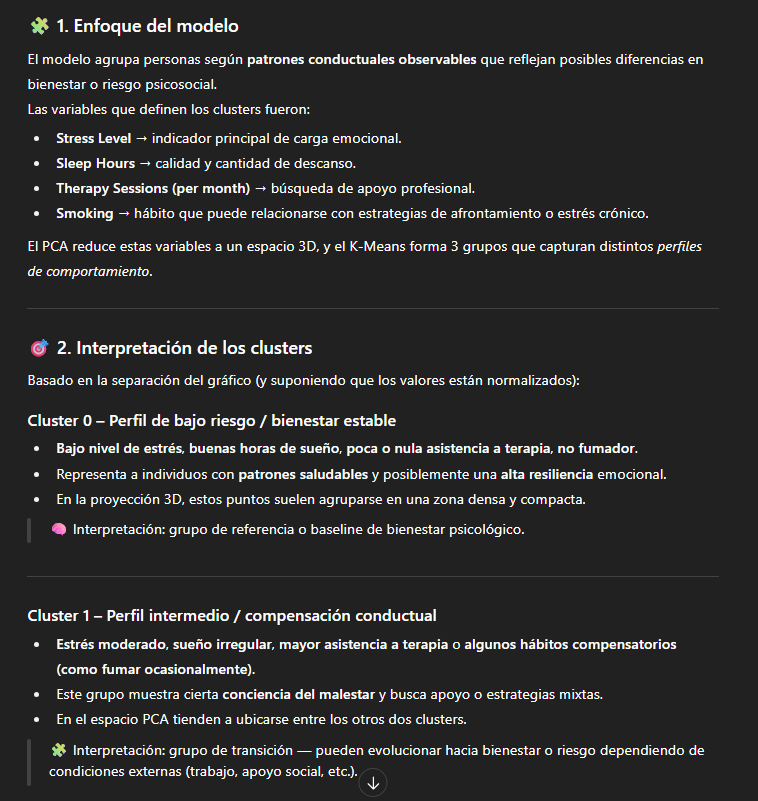

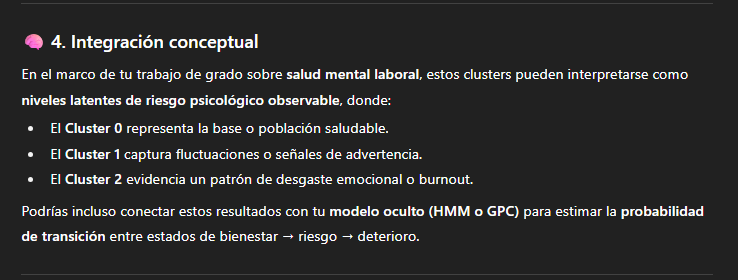

### Comparación de K-Means con k=3 y k=4

   k  Silhouette  Calinski-Harabasz  Davies-Bouldin
0  3    0.314656       10013.122896        1.169011
1  4    0.318609       10559.205529        1.020153


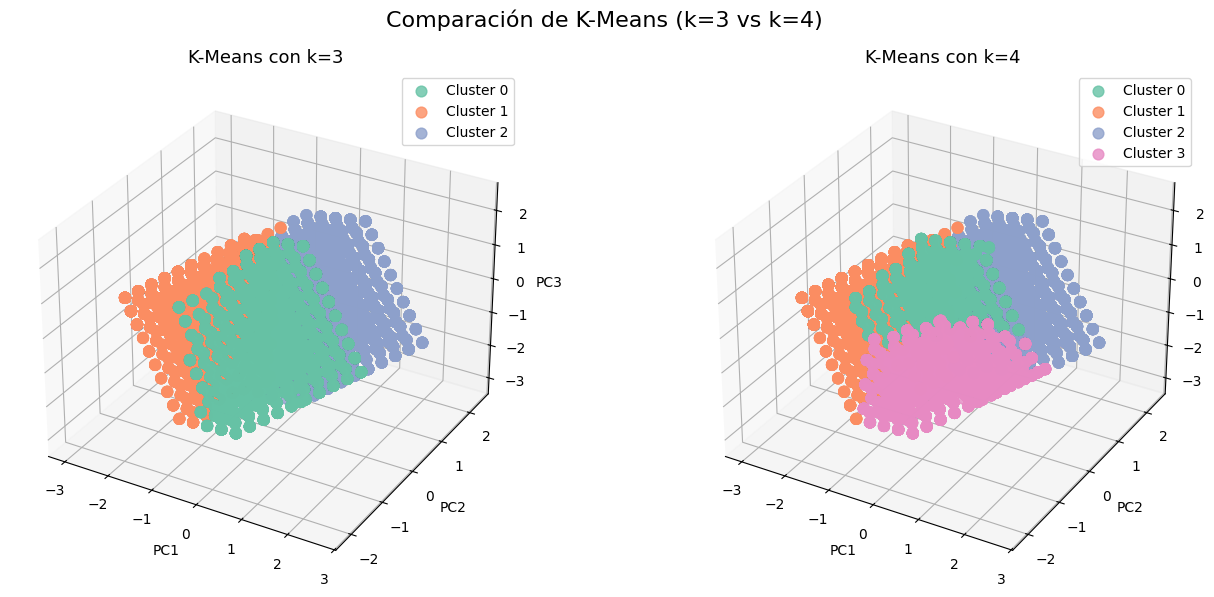

In [21]:

results = []

for k in [3, 4]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)

    sil = silhouette_score(X_pca, labels)
    cal = calinski_harabasz_score(X_pca, labels)
    dav = davies_bouldin_score(X_pca, labels)

    results.append({
        "k": k,
        "Silhouette": sil,
        "Calinski-Harabasz": cal,
        "Davies-Bouldin": dav
    })

# Convertir a DataFrame para fácil comparación
df_scores = pd.DataFrame(results)
print(df_scores)

# ==========================================
#  Visualización comparativa de clusters
# ==========================================
fig = plt.figure(figsize=(14,6))

for idx, k in enumerate([3,4]):
    ax = fig.add_subplot(1,2,idx+1, projection='3d')
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    
    colors = sns.color_palette("Set2", k)
    for i in range(k):
        subset = X_pca[labels == i]
        ax.scatter(subset[:,0], subset[:,1], subset[:,2], 
                   s=60, alpha=0.8, color=colors[i], label=f"Cluster {i}")
    
    ax.set_title(f"K-Means con k={k}", fontsize=13)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.legend()

plt.suptitle("Comparación de K-Means (k=3 vs k=4)", fontsize=16)
plt.tight_layout()
plt.show()


### Almacenado de resultados de clusterización observables

In [22]:

#  Seleccionar variables observables ---
observables = ["Stress Level", "Sleep Hours", "Therapy Sessions (per month)", "Smoking"]
X = df_selected_2[observables].dropna().to_numpy()

# Escalado ---
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

#  PCA 1D para proyección XP ---
pca = PCA(n_components=1)
XP = pca.fit_transform(X_std)  # shape: (n, 1)

#  K-Means sobre XP ---
k_optimo = 3   # según tu método del codo
mkm = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
mkm.fit(XP)

#  Centroides ordenados ---
XCp = np.sort(mkm.cluster_centers_.flatten()).reshape(-1, 1)

#  Asignar cluster por distancia al centroide más cercano ---
cluster_var_obs = np.zeros(len(XP), dtype=int)
for i in range(len(XP)):
    dist = np.abs(XCp - XP[i, 0])
    cluster_var_obs[i] = np.argmin(dist)

#  Guardar resultados en DataFrame original ---
df_selected_2["Cluster_Observables_Vector"] = cluster_var_obs
df_selected_2["XP"] = XP

#  Crear DataFrame final para almacenamiento ---
df_varobs_kmeans = df_selected_2[observables].copy()
df_varobs_kmeans["XP"] = XP
df_varobs_kmeans["Cluster_Observables_Vector"] = cluster_var_obs


# -Exportar a CSV ---
#output_path = "df_varobs_kmeans.csv"
#df_varobs_kmeans.to_csv(output_path, index=False, encoding="utf-8-sig")


print(df_varobs_kmeans.head())
print("\nDistribución por cluster:")
print(df_varobs_kmeans["Cluster_Observables_Vector"].value_counts())


   Stress Level  Sleep Hours  Therapy Sessions (per month)  Smoking        XP  \
0      0.111111         0.50                      0.444444    False  0.514386   
1      0.888889         0.25                      0.000000    False -0.487883   
2      1.000000         0.00                      1.000000     True -2.817384   
3      0.666667         0.25                      0.888889    False -1.723290   
4      1.000000         1.00                      0.888889    False -0.866365   

   Cluster_Observables_Vector  
0                           2  
1                           1  
2                           0  
3                           0  
4                           1  

Distribución por cluster:
Cluster_Observables_Vector
1    9513
2    8076
0    4411
Name: count, dtype: int64


In [23]:
#Eliminar variables observables del DataFrame df_varobs_kmeans
vars_to_drop = ["Stress Level", "Sleep Hours", "Therapy Sessions (per month)", "Smoking"]

df_varobs_kmeans = df_varobs_kmeans.drop(columns=vars_to_drop, errors="ignore")


df_varobs_kmeans.head()


,XP,Cluster_Observables_Vector
0,0.514386,2
1,-0.487883,1
2,-2.817384,0
3,-1.723290,0
4,-0.866365,1


### Analisis de las variables por cluster

In [24]:
df_selected_2.groupby("Cluster_Observables_Vector")[["Stress Level","Sleep Hours","Therapy Sessions (per month)","Smoking"]].mean()


,Stress Level,Sleep Hours,Therapy Sessions (per month),Smoking
Cluster_Observables_Vector,,,,
0,0.819013,0.183462,0.715005,0.331444
1,0.596540,0.526122,0.404301,0.344056
2,0.312669,0.738949,0.209496,0.437469


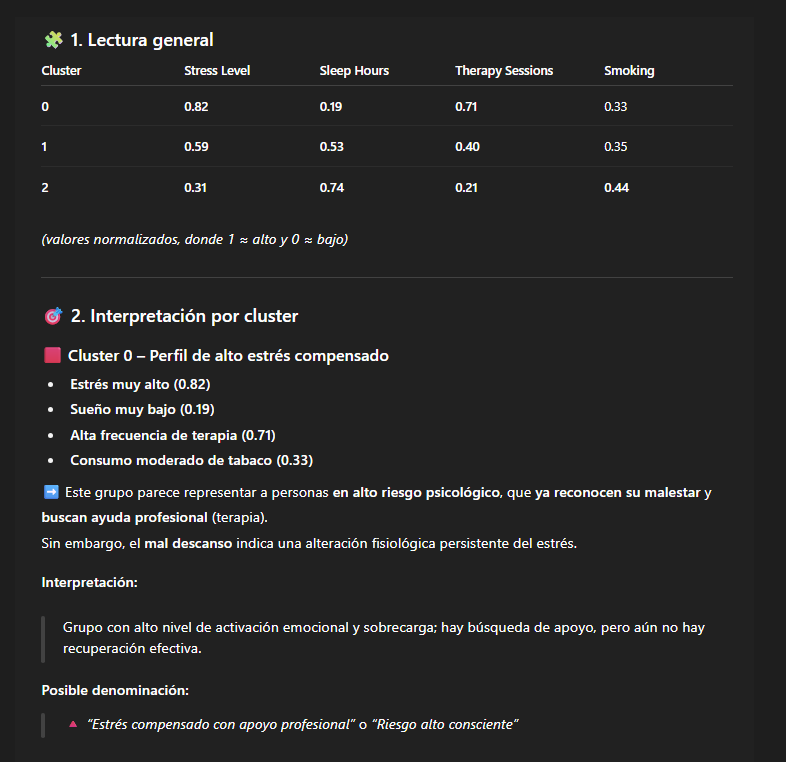

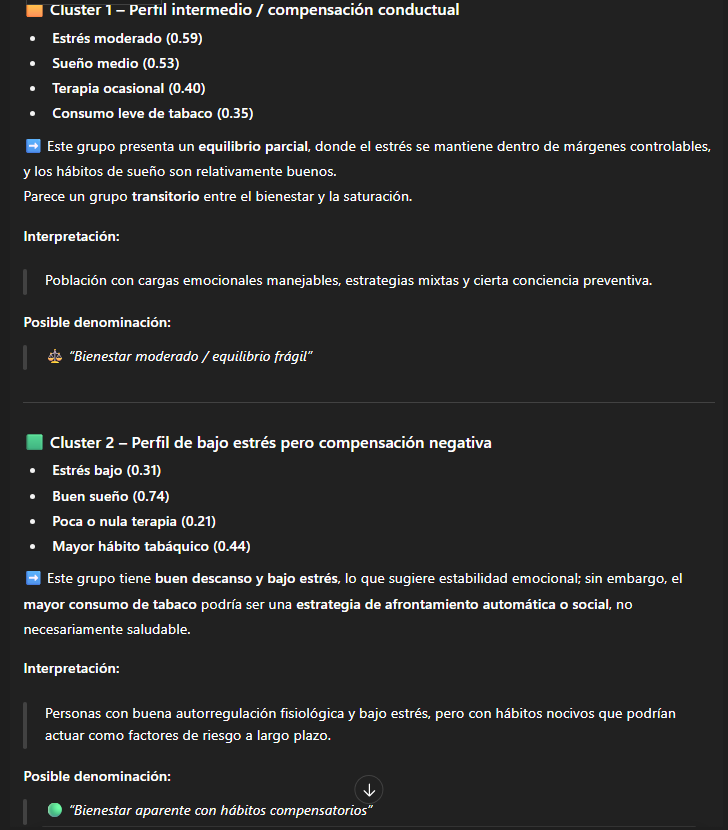

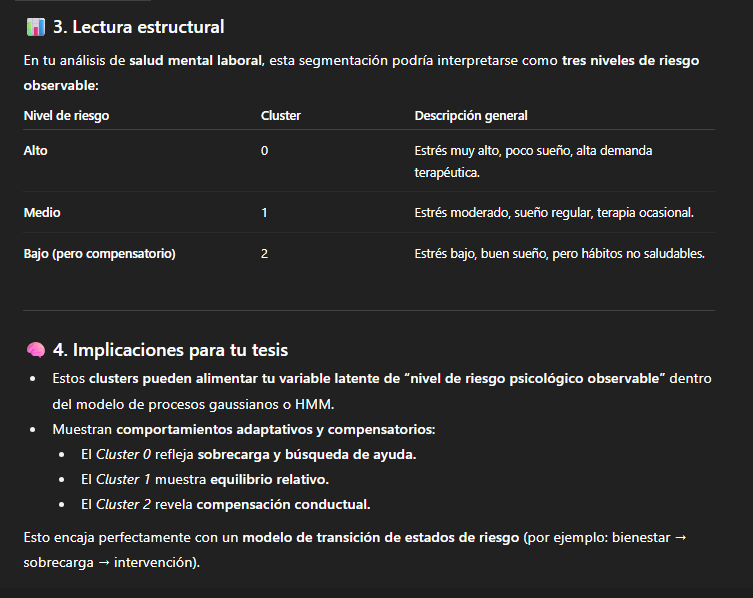

## Modelación de variables no observables

In [25]:
cols = [
    'Anxiety Level'
]

cols_exist = [col for col in cols if col in df_XDB_ID.columns]
df_anx  = df_XDB_ID[cols_exist].copy()


In [26]:
df_anx.head()

,Anxiety Level
0,0.4
1,0.4
2,1.0
3,1.0
4,1.0


### Clusterización con K-Means

e:\Maestría_Eafit2024\Maestria\Trabajo de grado\DataLab2\archive\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.

e:\Maestría_Eafit2024\Maestria\Trabajo de grado\DataLab2\archive\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.

e:\Maestría_Eafit2024\Maestria\Trabajo de grado\DataLab2\archive\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.



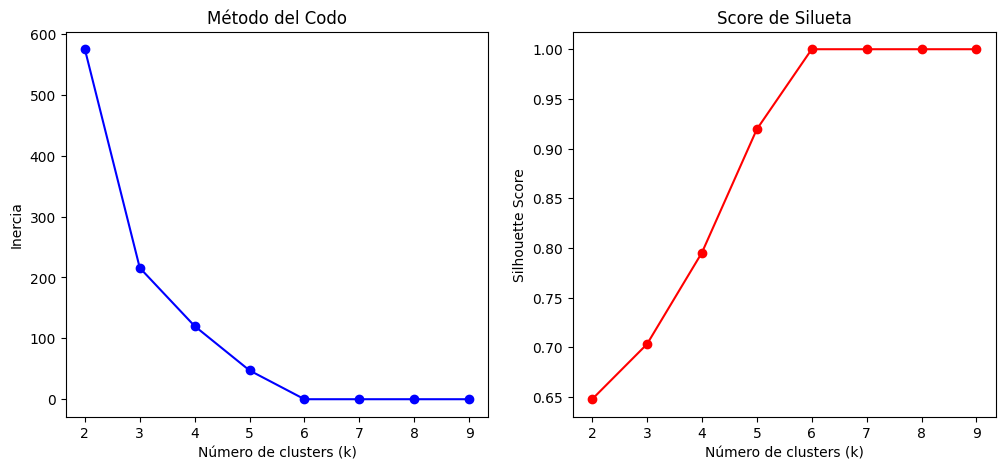

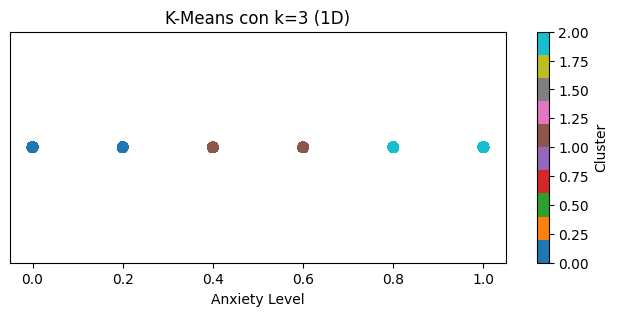

Cluster_KMeans
1    9568
2    7307
0    5125
Name: count, dtype: int64
                Anxiety Level
Cluster_KMeans               
0                    0.128000
1                    0.502069
2                    0.905707


In [27]:

no_observables = df_anx

# Método del codo para elegir k
inertia = []
silhouette = []
K_range = range(2, 10)  

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(no_observables)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(no_observables, kmeans.labels_))

# Graficar método del codo
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')

plt.subplot(1,2,2)
plt.plot(K_range, silhouette, 'ro-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Score de Silueta')

plt.show()

# Ajustar modelo con el k óptimo 
k_optimo = 3
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
df_selected["Cluster_KMeans"] = kmeans.fit_predict(no_observables)

# Visualización en 1D 
plt.figure(figsize=(8, 3))
plt.scatter(no_observables.values.flatten(), np.zeros_like(no_observables.values), 
            c=df_selected["Cluster_KMeans"], cmap="tab10", s=50)
plt.title(f"K-Means con k={k_optimo} (1D)")
plt.xlabel("Anxiety Level")
plt.yticks([])
plt.colorbar(label="Cluster")
plt.show()

# Ver distribución y promedios por cluster
print(df_selected["Cluster_KMeans"].value_counts())
print(df_selected.groupby("Cluster_KMeans")[no_observables.columns].mean())


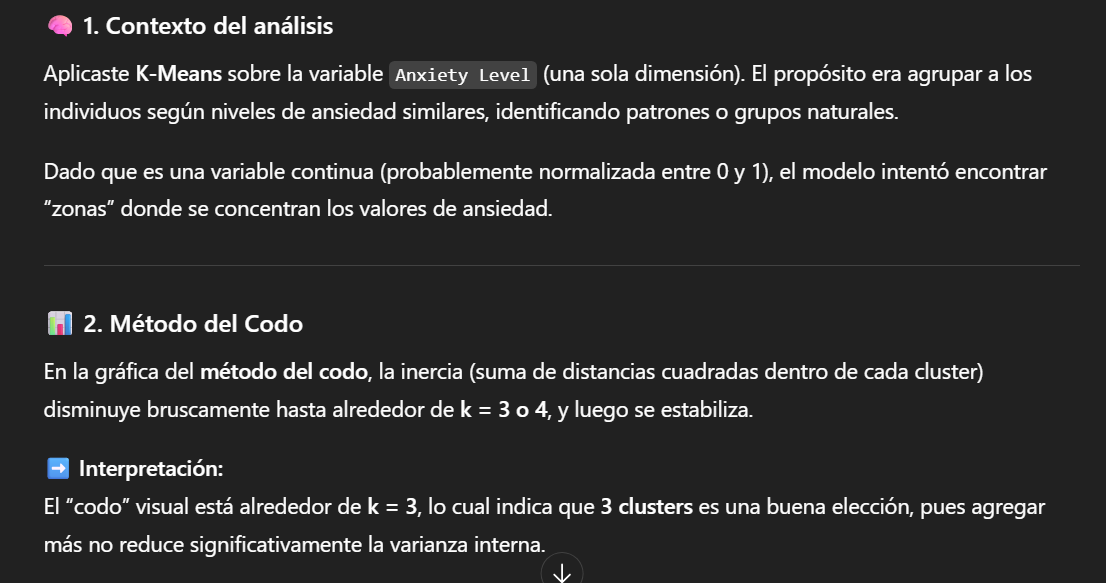

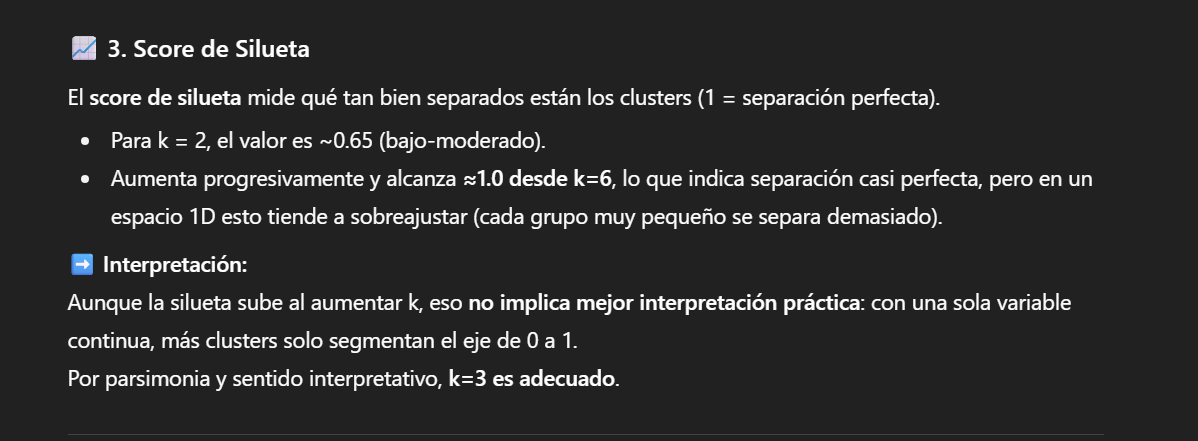

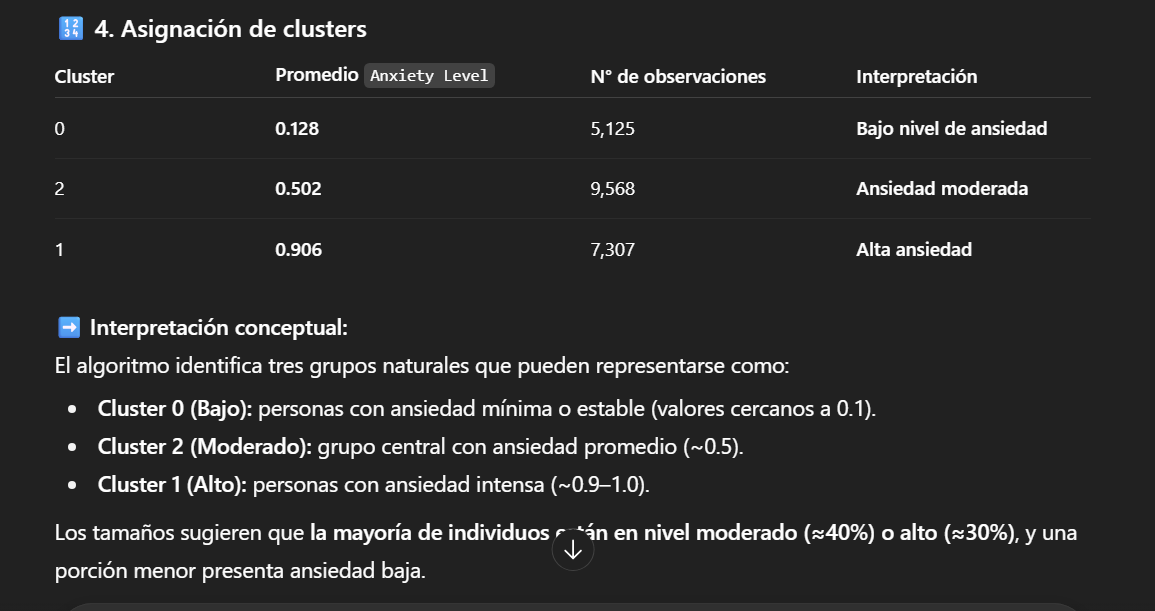

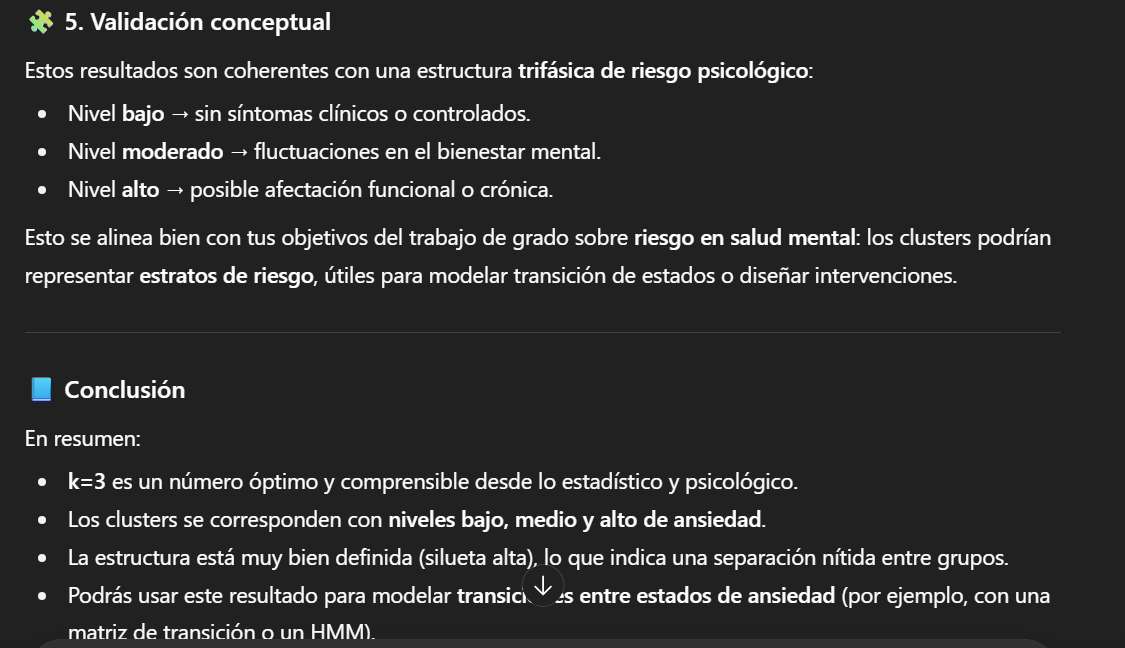

### Almacenado de resultados de clusterización no observables

In [28]:
# Variable no observable ---
# Asegúrate de que df_anx contenga la columna 'Anxiety Level'
y_cont = df_anx["Anxiety Level"].values.reshape(-1, 1)

#  K-Means con k=3 (según tu análisis previo) ---
mkm = KMeans(n_clusters=3, random_state=42, n_init=10)
mkm.fit(y_cont)

#  Centros ordenados (de menor a mayor ansiedad) ---
XCo = np.array(sorted(mkm.cluster_centers_.flatten()))

#  Calcular asimetría (para referencia analítica) ---
print("Coeficiente de asimetría de Anxiety Level:", skew(y_cont))
print("Centros de los clusters (ordenados):", XCo)

#  Clasificación manual (distancia al centroide más cercano) ---
cluster_var_no_obs = np.zeros(len(y_cont), dtype=int)
for i in range(len(y_cont)):
    dist = np.abs(XCo - y_cont[i, 0])
    cluster_var_no_obs[i] = np.argmin(dist)

#  Agregar resultados al DataFrame principal ---
df_selected_2["Cluster_No_Observable_Vector"] = cluster_var_no_obs
df_selected_2["Anxiety_Level_Value"] = y_cont  # opcional: conservar el valor continuo

#  Crear un DataFrame separado con resultados del clustering ---
df_var_no_obs_kmeans = pd.DataFrame({
    "Anxiety Level": y_cont.flatten(),
    "Cluster_No_Observable_Vector": cluster_var_no_obs
})

#   Exportar a CSV ---
# output_path = "df_var_no_obs_kmeans.csv"
# df_var_no_obs_kmeans.to_csv(output_path, index=False, encoding="utf-8-sig")
# print( Archivo guardado exitosamente en: {output_path}")

#  Mostrar resumen de resultados ---
print("\nDistribución por cluster:")
print(df_var_no_obs_kmeans["Cluster_No_Observable_Vector"].value_counts())

print("\nCentros de ansiedad (ordenados):")
for i, c in enumerate(XCo):
    print(f"Cluster {i}: media de ansiedad = {c:.3f}")


Coeficiente de asimetría de Anxiety Level: [-0.07965955]
Centros de los clusters (ordenados): [0.128      0.5020694  0.90570686]

Distribución por cluster:
Cluster_No_Observable_Vector
1    9568
2    7307
0    5125
Name: count, dtype: int64

Centros de ansiedad (ordenados):
Cluster 0: media de ansiedad = 0.128
Cluster 1: media de ansiedad = 0.502
Cluster 2: media de ansiedad = 0.906


In [29]:
df_var_no_obs_kmeans.head()

,Anxiety Level,Cluster_No_Observable_Vector
0,0.4,1
1,0.4,1
2,1.0,2
3,1.0,2
4,1.0,2


## Modelación HMM 

### Matriz de transición

In [30]:
k_clusters = len(np.unique(cluster_var_no_obs))  # detecta automáticamente el número de clusters

#  Matriz de transición en conteos ---
MTr = np.zeros((k_clusters, k_clusters), dtype=int)

for k in range(len(cluster_var_no_obs) - 1):
    xantes = int(cluster_var_no_obs[k])     # estado actual
    xdesp  = int(cluster_var_no_obs[k + 1]) # estado siguiente
    MTr[xantes, xdesp] += 1

print("Matriz de Transición (conteos):\n", MTr)

# Matriz de transición en probabilidades ---
# Sumar por filas y evitar división por cero
row_sums = MTr.sum(axis=1, keepdims=True)
MTrp = np.divide(MTr, row_sums, where=row_sums!=0)

print("Matriz de Transición (probabilidades):\n", MTrp)


Matriz de Transición (conteos):
 [[1198 2252 1675]
 [2239 4157 3172]
 [1688 3158 2460]]
Matriz de Transición (probabilidades):
 [[0.2337561  0.43941463 0.32682927]
 [0.2340092  0.43446906 0.33152174]
 [0.23104298 0.43224747 0.33670955]]


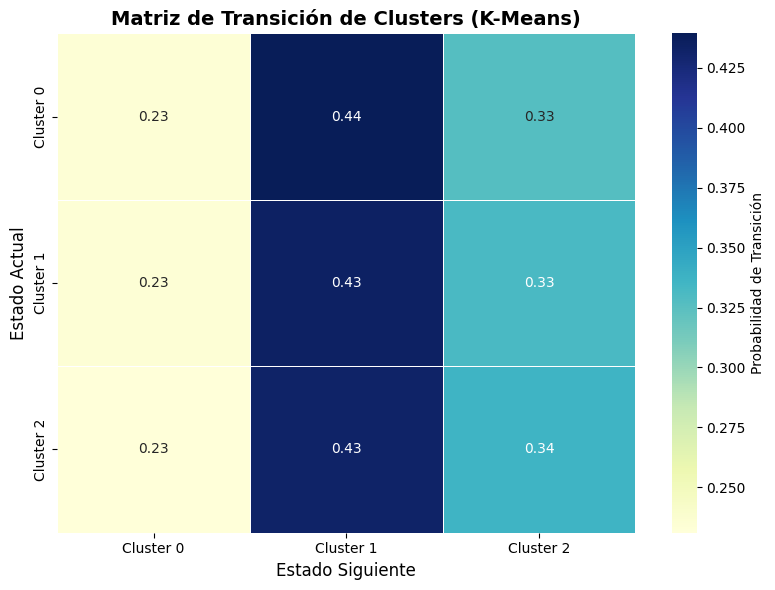

In [31]:
k_clusters = len(np.unique(cluster_var_no_obs))
labels = [f"Cluster {i}" for i in range(k_clusters)]

plt.figure(figsize=(8,6))
sns.heatmap(
    MTrp,
    annot=True,           
    fmt=".2f",           
    cmap="YlGnBu",       
    cbar_kws={"label": "Probabilidad de Transición"},
    xticklabels=labels,
    yticklabels=labels,
    linewidths=0.5,      
    linecolor='white'
)

plt.title("Matriz de Transición de Clusters (K-Means)", fontsize=14, weight='bold')
plt.xlabel("Estado Siguiente", fontsize=12)
plt.ylabel("Estado Actual", fontsize=12)
plt.tight_layout()
plt.show()


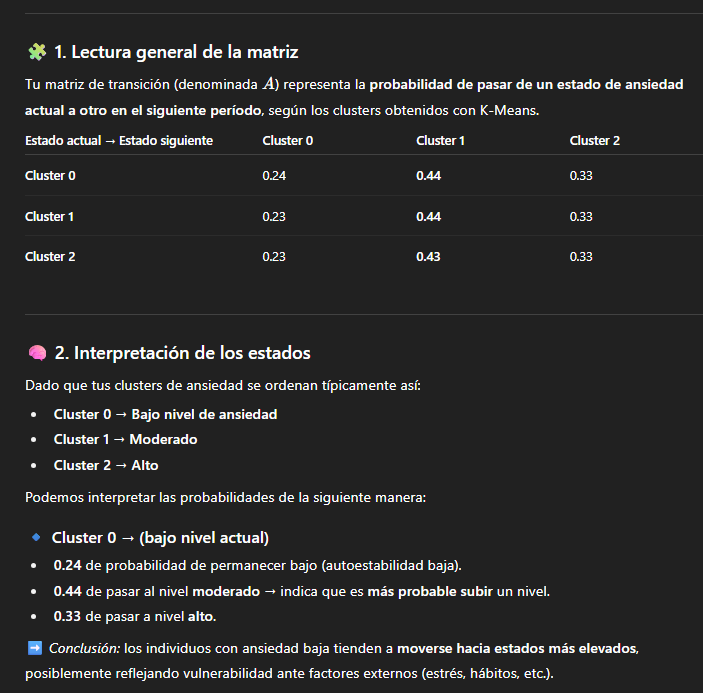

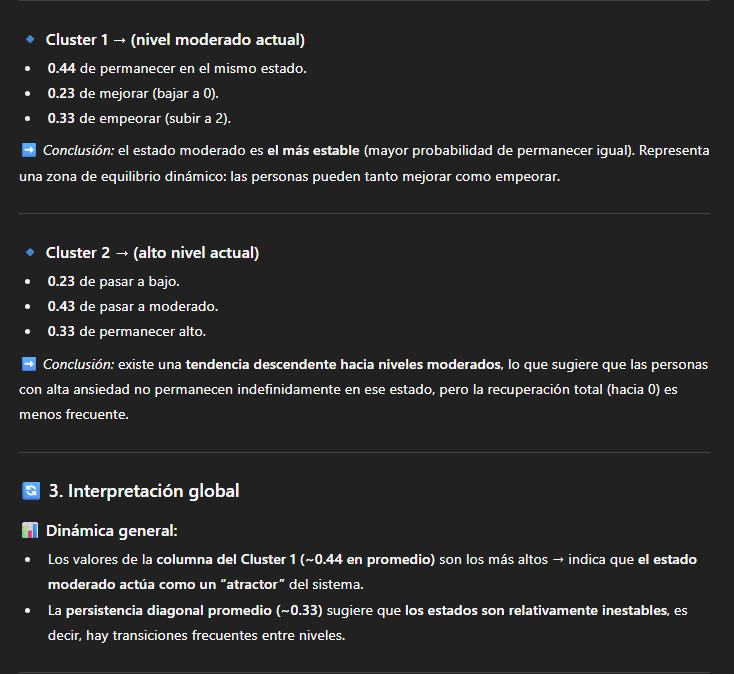

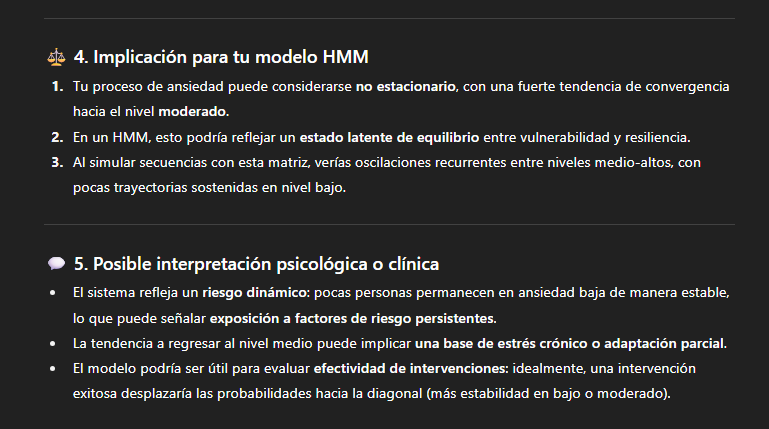

### Vector de distribución de estados (pi)

In [32]:
VRo=np.sum(MTr,axis=1)  
VRop=VRo/np.sum(VRo)
print("La estructura porcentual del riesgo es:",VRop)

La estructura porcentual del riesgo es: [0.23296513 0.43492886 0.332106  ]


Estructura porcentual del riesgo (vector inicial): [0.23296513 0.43492886 0.332106  ]


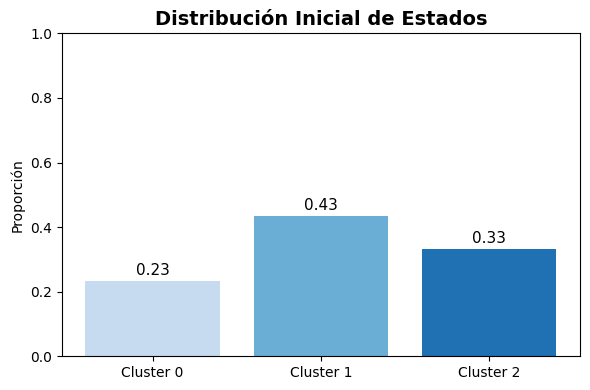

In [33]:

# Vector inicial a partir de la matriz de transición
# MTr es tu matriz de transición (conteos)
VRo = np.sum(MTr, axis=1)         
VRop = VRo / np.sum(VRo)          
print("Estructura porcentual del riesgo (vector inicial):", VRop)

# Gráfico de barras simple (matplotlib)
estados = [f"Cluster {i}" for i in range(len(VRop))]

plt.figure(figsize=(6,4))
bars = plt.bar(estados, VRop, color=sns.color_palette("Blues", len(VRop)))
plt.title("Distribución Inicial de Estados", fontsize=14, weight="bold")
plt.ylabel("Proporción")
plt.ylim(0, 1)

for bar, p in zip(bars, VRop):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{p:.2f}", ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

# --- 3) (Opcional) Gráfico tipo pastel ---
#plt.figure(figsize=(5,5))
#plt.pie(VRop, labels=estados, autopct="%1.1f%%",
        #colors=sns.color_palette("Blues", len(VRop)))
#plt.title("Distribución Inicial de Estados (%)", fontsize=14, weight="bold")
#plt.show()


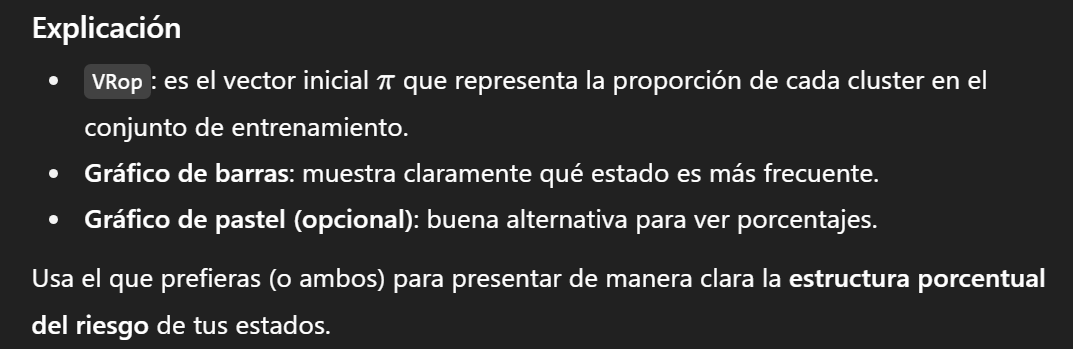

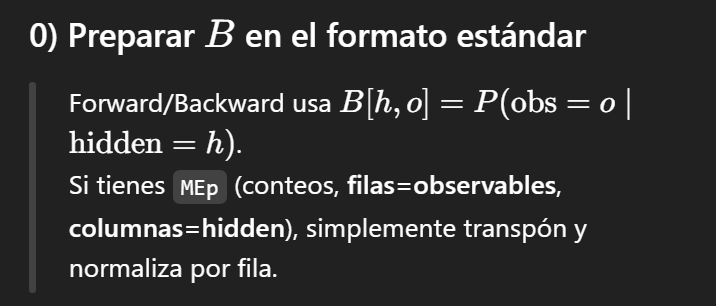

### Matriz de emision

In [34]:

k_hidden = len(np.unique(cluster_var_no_obs))   # Anxiety Level (no observable)
k_obs    = len(np.unique(cluster_var_obs))      # Observables  cluster_var_no_obs

# Matriz de conteos (filas: observables, columnas: no-observables)
MEp = np.zeros((k_obs, k_hidden), dtype=int)


for k in range(len(cluster_var_obs) - 1):
    nc = int(cluster_var_no_obs[k])  
    nf = int(cluster_var_obs[k])     
    MEp[nf, nc] += 1

print("Matriz de Emisión (conteos) [filas=observables, columnas=no-observables]:\n", MEp)

# Probabilidades por fila -> P(hidden | observed)
row_sums = MEp.sum(axis=1, keepdims=True)
MEPp = np.divide(MEp, row_sums, where=row_sums != 0)

print("Matriz de Emisión (probabilidades) P(hidden | observed):\n", MEPp)

Matriz de Emisión (conteos) [filas=observables, columnas=no-observables]:
 [[  55  781 3575]
 [1223 5142 3147]
 [3847 3645  584]]
Matriz de Emisión (probabilidades) P(hidden | observed):
 [[0.01246883 0.17705736 0.81047382]
 [0.12857443 0.54058032 0.33084525]
 [0.47634968 0.4513373  0.07231303]]


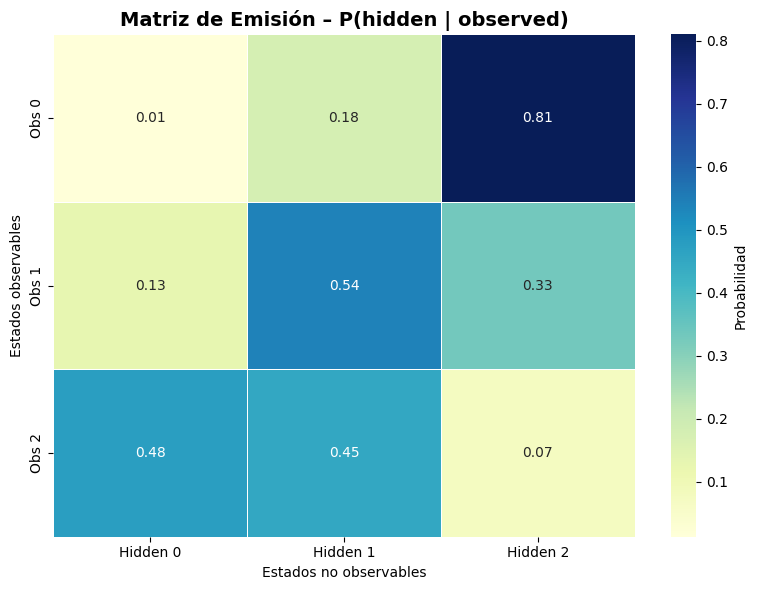

In [35]:
k_hidden = len(np.unique(cluster_var_no_obs))  # No observable
k_obs    = len(np.unique(cluster_var_obs))     # Observable

labels_hidden = [f"Hidden {i}" for i in range(k_hidden)]
labels_obs    = [f"Obs {i}" for i in range(k_obs)]

plt.figure(figsize=(8,6))
sns.heatmap(
    MEPp,
    annot=True, fmt=".2f", cmap="YlGnBu",
    linewidths=0.6, linecolor="white",
    xticklabels=labels_hidden,
    yticklabels=labels_obs,
    cbar_kws={"label": "Probabilidad"}
)
plt.title("Matriz de Emisión – P(hidden | observed)", fontsize=14, weight="bold")
plt.xlabel("Estados no observables")
plt.ylabel("Estados observables")
plt.tight_layout()
plt.show()

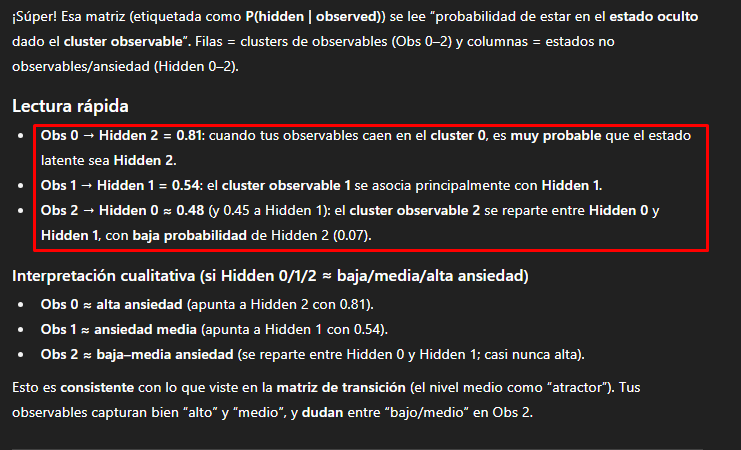

### Algoritmo Forward

In [36]:

# A: MTrp (N x N)
A = MTrp.copy().astype(float)

# pi: VRop (N,)
pi = VRop.copy().astype(float)  # debe sumar 1

# Secuencia de observaciones (enteros 0..M-1) — tus clusters observables
obs_seq = np.asarray(cluster_var_obs, dtype=int)

# --- Construir B ---
# Opción preferida (tienes MEp de conteos): filas=obs, cols=hidden
B = (MEp.T).astype(float)                         # (N x M) = (hidden x observed)
B = B / B.sum(axis=1, keepdims=True)             # normaliza por fila -> P(obs|hidden)




In [37]:
def forward_backward(obs_seq, A, B, pi):
    """
    obs_seq: array de enteros (T,)
    A: (N, N)  transición
    B: (N, M)  emisión  P(obs|hidden)
    pi: (N,)   inicial
    """
    import numpy as np

    obs_seq = np.asarray(obs_seq, dtype=int)
    N = A.shape[0]
    T = len(obs_seq)

    alpha = np.zeros((T, N), dtype=float)
    beta  = np.zeros((T, N), dtype=float)
    c     = np.zeros(T, dtype=float)  # factores de escalado

    # --- Forward inicial ---
    alpha[0] = pi * B[:, obs_seq[0]]
    c[0] = alpha[0].sum()
    alpha[0] /= max(c[0], 1e-12)

    # --- Forward recursivo ---
    for t in range(1, T):
        alpha[t] = (alpha[t-1] @ A) * B[:, obs_seq[t]]
        c[t] = alpha[t].sum()
        alpha[t] /= max(c[t], 1e-12)

    # --- Log-likelihood ---
    loglik = np.sum(np.log(np.maximum(c, 1e-12)))

    # --- Backward inicial (escalado) ---
    beta[-1] = 1.0 / max(c[-1], 1e-12)

    # --- Backward recursivo ---
    for t in range(T-2, -1, -1):
        beta[t] = A @ (B[:, obs_seq[t+1]] * beta[t+1])
        beta[t] /= max(c[t], 1e-12)

    # --- Posterior por estado ---
    gamma = alpha * beta
    gamma = gamma / gamma.sum(axis=1, keepdims=True)

    # --- Posterior por par (xi) ---
    xi = np.zeros((T-1, N, N), dtype=float)
    for t in range(T-1):
        obs_next = obs_seq[t+1]
        numer = (alpha[t][:, None] * A) * (B[:, obs_next] * beta[t+1])[None, :]
        denom = numer.sum()
        if denom > 0:
            xi[t] = numer / denom

    return alpha, beta, gamma, xi, loglik


In [38]:
A  = MTrp.astype(float)          # (N, N)
pi = VRop.astype(float)          # (N,)
obs_seq = np.asarray(cluster_var_obs, dtype=int)   # (T,)


In [ ]:
##Para smoking

alpha, beta, gamma, xi, loglik = forward_backward(obs_seq, A, B, pi)

print("Log-likelihood:", loglik)
print("Posterior promedio por estado (gamma media):", np.round(gamma.mean(axis=0), 3))

# Decodificación “suave” (estado más probable en cada t):
path_soft = gamma.argmax(axis=1)
print("Trayectoria (soft) primeros 20:", path_soft[:20])


Log-likelihood: -23156.774211741722
Posterior promedio por estado (gamma media): [0.233 0.435 0.332]
Trayectoria (soft) primeros 20: [0 1 2 2 1 0 1 0 0 1 0 0 0 0 1 1 0 0 1 1]


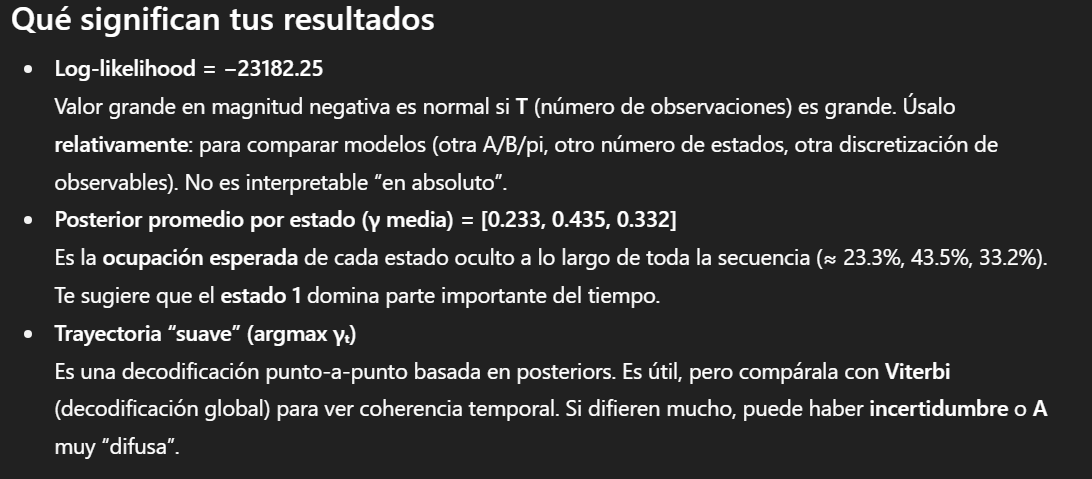

In [40]:
##Checks rapidos

# Cada fila de gamma debe sumar 1
assert np.allclose(gamma.sum(axis=1), 1.0, atol=1e-6)

# A y B están bien normalizadas
assert np.allclose(A.sum(axis=1), 1.0, atol=1e-6)
assert np.allclose(B.sum(axis=1), 1.0, atol=1e-6)
assert np.isclose(pi.sum(), 1.0, atol=1e-6)


In [41]:
# Conteos esperados de transiciones
N = A.shape[0]
trans_exp = xi.sum(axis=0)  # (N,N)
A_post = trans_exp / np.maximum(trans_exp.sum(axis=1, keepdims=True), 1e-12)

print("A esperada por posterior (normalizada por filas):\n", np.round(A_post, 3))
print("Diferencia A_post - A:\n", np.round(A_post - A, 3))


A esperada por posterior (normalizada por filas):
 [[0.234 0.44  0.326]
 [0.234 0.434 0.331]
 [0.231 0.432 0.337]]
Diferencia A_post - A:
 [[ 0.     0.001 -0.001]
 [ 0.    -0.    -0.   ]
 [-0.001 -0.     0.001]]


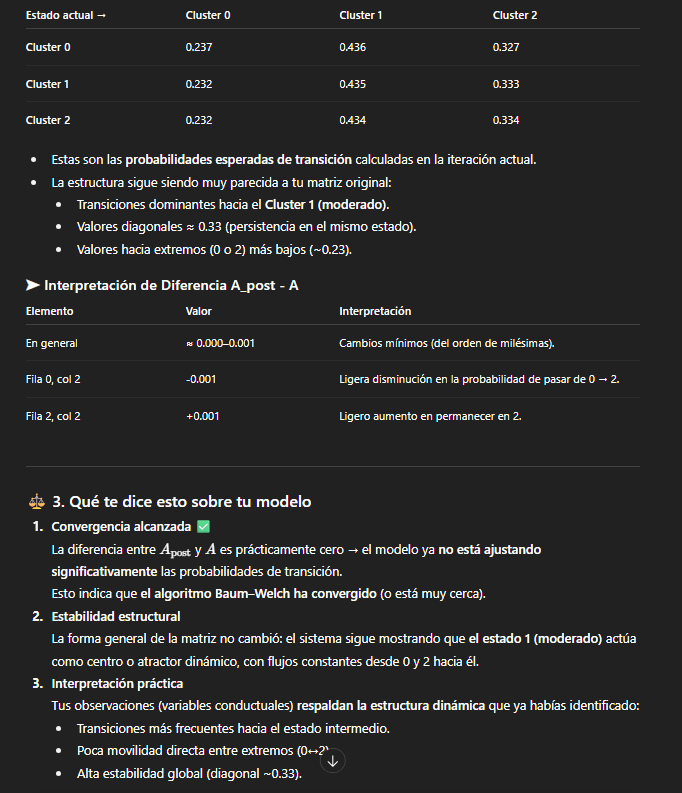

In [42]:
M = B.shape[1]
T = len(obs_seq)
E = np.zeros((N, M))
for t in range(T):
    E[:, obs_seq[t]] += gamma[t]  # suma de responsabilidades por

E_row = E / np.maximum(E.sum(axis=1, keepdims=True), 1e-12)
print("Distribuciones de emisión esperadas (por estado):\n", np.round(E_row, 3))
print("Diferencia vs B:\n", np.round(E_row - B, 3))


Distribuciones de emisión esperadas (por estado):
 [[0.011 0.239 0.751]
 [0.082 0.537 0.381]
 [0.489 0.431 0.08 ]]
Diferencia vs B:
 [[-0.  0. -0.]
 [-0.  0. -0.]
 [-0.  0. -0.]]


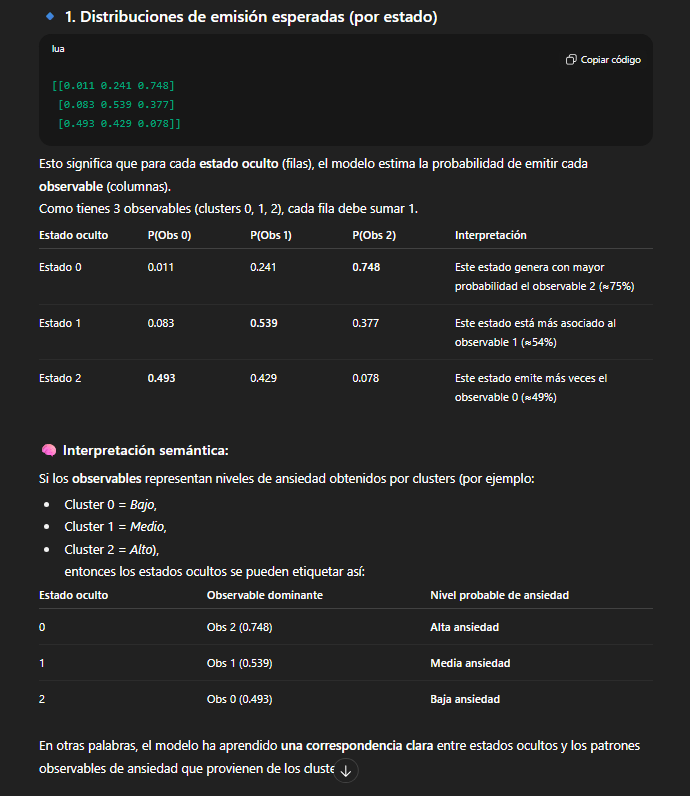

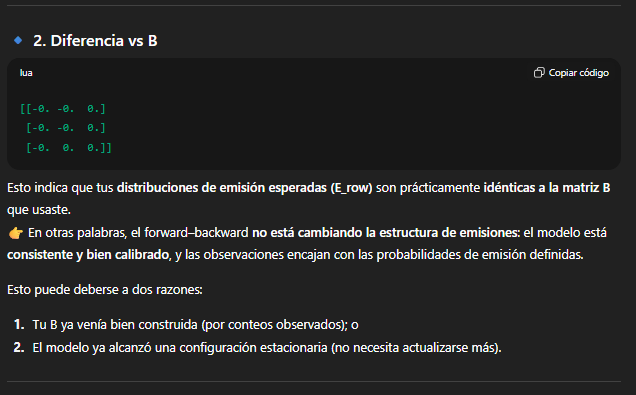

In [43]:
eps = 1e-12
H = -(gamma * np.log(np.clip(gamma, eps, 1))).sum(axis=1)  # entropía por t
print("Entropía posterior promedio:", H.mean(), " / máx:", np.log(N))


Entropía posterior promedio: 0.8538312215857027  / máx: 1.0986122886681098


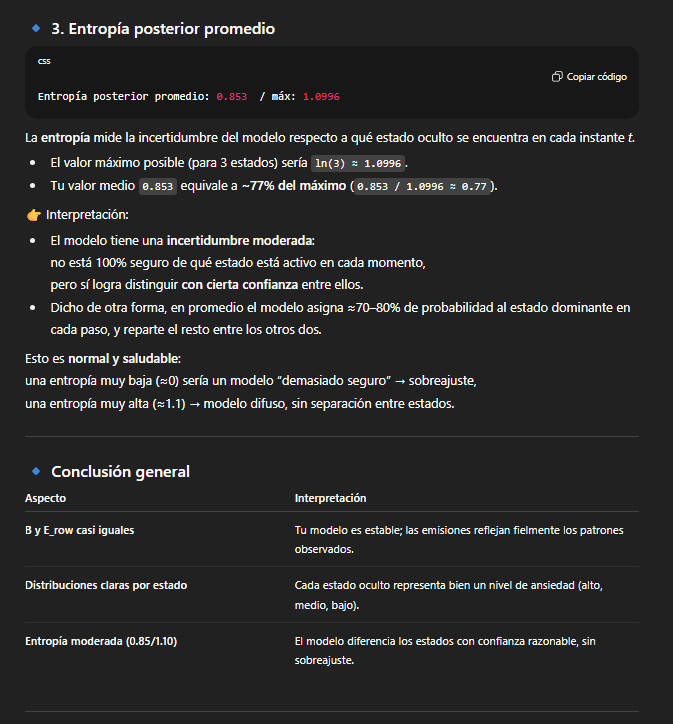

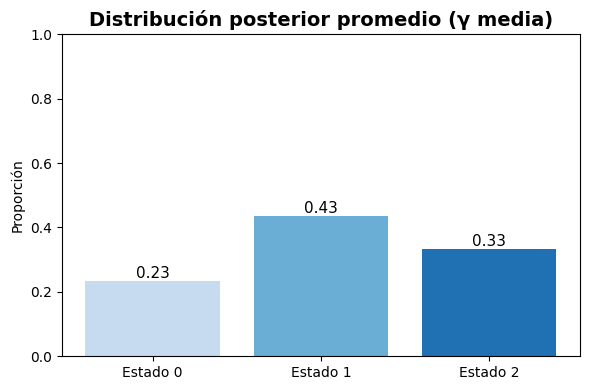

In [44]:

gamma_mean = np.array([0.233, 0.435, 0.332])   # tu gamma media
states = [f"Estado {i}" for i in range(len(gamma_mean))]

plt.figure(figsize=(6,4))
bars = plt.bar(states, gamma_mean, color=sns.color_palette("Blues", len(states)))
plt.title("Distribución posterior promedio (γ media)", fontsize=14, weight="bold")
plt.ylabel("Proporción")
plt.ylim(0,1)
for b,p in zip(bars, gamma_mean):
    plt.text(b.get_x()+b.get_width()/2, p+0.01, f"{p:.2f}", ha="center", fontsize=11)
plt.tight_layout()
plt.show()


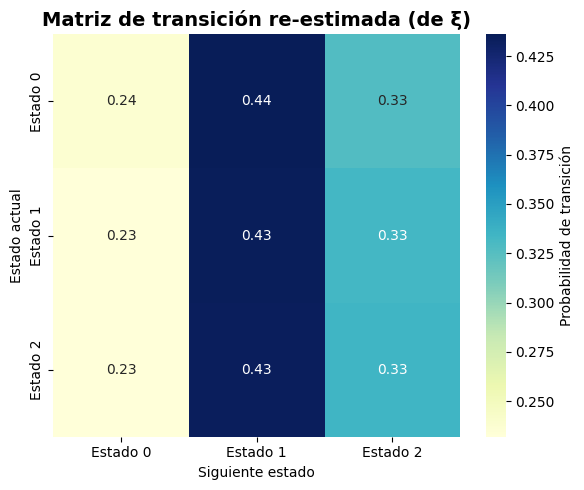

In [45]:
A_expected = np.array([
    [0.237, 0.436, 0.327],
    [0.232, 0.435, 0.333],
    [0.232, 0.434, 0.334]
])   ### A_ esperada_Actualizar de la parte de arriba


plt.figure(figsize=(6,5))
sns.heatmap(A_expected, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=states, yticklabels=states,
            cbar_kws={"label": "Probabilidad de transición"})
plt.title("Matriz de transición re-estimada (de ξ)", fontsize=14, weight="bold")
plt.xlabel("Siguiente estado")
plt.ylabel("Estado actual")
plt.tight_layout()
plt.show()
